# 1. Load Data
## 1.1 Unlabeled articles

In [76]:
# import library
import os
import glob
import pandas as pd
import numpy as np
import re
import nltk
import string

# change working directory
path = r'C:\Users\LW130003\Desktop\New folder\SentenceCorpus'
os.chdir(path)

In [77]:
# function that will be used in section 1

def load_labeled():
    
    # inner function
    def load_text():
        # this function loads text file and extract info from filename
        # return: texts (in list), Domain, Article_Id, Annotator

        file_list = glob.glob(os.path.join(os.getcwd(), "labeled_articles", "*.txt"))
    
        corpus = []
        domain = []
        article_id = []
        annotator = []
    
        for file_path in file_list:
            filename = os.path.basename(file_path).split('_')
            domain.append(filename[0])
            article_id.append(filename[2])
            annotator.append(filename[3].split('.')[0])
            with open(file_path) as f_input:
                corpus.append(f_input.read())
                    
        return corpus, domain, article_id, annotator
    
    def to_df(string, domain, ID, annot):    
        # this function transform a text into a Dataframe which include the domain, article_id, annotator
        # inputs: text(string), domain of text, article_id, annotator

        # split into 2 types: texts found in abstract and introduction and split the labels and texts    
        abs_no = string.find('### abstract ###')
        intro_no = string.find('### introduction ###')
        abs1 = string[abs_no+len('### abstract ###')+1:intro_no].split('\n')
        intro1 = string[intro_no+len('### introduction ###')+1:].split('\n')
        
        abstract = []
        introduction = []
        # separate labels and text
        for idx, val in enumerate(abs1):
            val = val.split('\t')
            abstract.append(val)
        for idx, val in enumerate(intro1):
            val = val.split('\t')
            introduction.append(val)
        # create dataframe
        abstract = pd.DataFrame(abstract)
        abstract['type'] = 'abstract'
    
        introduction = pd.DataFrame(introduction)
        introduction['type'] = 'introduction'

        # combine abstract and introduction into one
        data = pd.concat([abstract, introduction])
    
        # rename column 0 -> labels and column 1 -> texts
        data.rename(columns={0: "labels", 1: "texts"}, inplace=True)
    
        # add domain, article_id, annotation
        data['domain'] = domain
        data['article_id'] = ID
        data['annotator'] = annot
    
        return data

    # this function load dataset that will be used for training ML model    
    dataframe = pd.DataFrame()
    corpus, domain, article_id, annotator = load_text()    
    # error checking length of corpus, domain, article_id, annotator must be equal
    if len(corpus) == len(domain) == len(article_id) == len(annotator):
        for i in range(len(corpus)):
            dataset = to_df(corpus[i], domain[i], article_id[i], annotator[i])
            dataframe = dataframe.append(dataset, ignore_index = True)  
    else:
        print('lengths are not equal, there might some problem in load_text()')
        
    return dataframe

In [78]:
# load labeled_articles
labeled = load_labeled()
labeled.tail()

annotator article_id domain  \
3263         3       1187   plos   
3264         3       1187   plos   
3265         3       1187   plos   
3266         3       1187   plos   
3267         3       1187   plos   

                                                 labels texts          type  \
3263  MISC This paved the way for the development of...   NaN  introduction   
3264  MISC To our knowledge, the first of these meth...   NaN  introduction   
3265  BASE Although our method, detailed in the foll...   NaN  introduction   
3266  OWNX By the latter we consider a seemingly tri...   NaN  introduction   
3267  OWNX The accuracy of the method makes it attra...   NaN  introduction   

        2  
3263  NaN  
3264  NaN  
3265  NaN  
3266  NaN  
3267  NaN

Here we could observe, that there are errors in separating the code due to extra space in text document. First, I will check the data that have values in column 2 and fix the typo.

In [79]:
# check the data that has value in row 2
labeled[labeled[2].notnull()]

annotator article_id domain labels  \
220         1         13  arxiv   MISC   

                                                 texts          type  \
220  since there is such a diversity among differen...  introduction   

                                   2  
220  characterize the composing ases

In [80]:
print(labeled.loc[220, 2])
print(labeled.loc[220,'texts'])

characterize the composing ases
since there is such a diversity among different network types  we cannot accurately augment the as level topology with appropriate router level topologies if we cannot MISC


Since there are only 1 problem. Let's just append it to the end of data and edit the typo.

In [81]:
labeled.loc[220,'texts'] = 'since there is such a diversity among different network types  we cannot accurately augment the as level topology with appropriate router level topologies if we cannot'
labeled.drop(columns=2, inplace=True)
# append the data at the end of dataset
labeled.loc[labeled.shape[0]+1] = ['1', '13', 'arxiv', 'MISC', 'characterize the composing ases', 'introduction']
# check if the fix has been applied
print(labeled.loc[220,'texts'], '\n\n', labeled.tail(1))

since there is such a diversity among different network types  we cannot accurately augment the as level topology with appropriate router level topologies if we cannot 

      annotator article_id domain labels                            texts  \
3269         1         13  arxiv   MISC  characterize the composing ases   

              type  
3269  introduction  


Next is to fix the row where the text are still connected with the labels. Luckily, Luckyly, all the labels are 4 letter words. Therefore, it is possible fix the problem by slicing the first 4 letters to 'label' column and 5th to end letters to 'text' column.

In [82]:
# get the index of the rows with problem 1
prob_idx = labeled[labeled['texts'].isnull()].index.tolist()
# loop reimpute the data
for idx in prob_idx:
    labeled.loc[idx,'texts'] = labeled.loc[idx,'labels'][5:]
    labeled.loc[idx,'labels'] = labeled.loc[idx,'labels'][0:4]
# check the data
print('Number of missing texts: {}'.format(labeled['texts'].isnull().sum()))

Number of missing texts: 0


Summarize data

In [83]:
labeled.describe(include=['O'])

annotator article_id domain labels texts          type
count       3269       3269   3269   3269  3269          3269
unique         3         30      3      7  1415             2
top            3        120   plos   MISC        introduction
freq        1095        236   1162   1826   151          2576

From data description, it is observed that althought there should be no missing value as there are no missing count, there are 7 types of labels and the largest number of text is '' which is quite strange. Let's print the unique labels and data with empty text.

In [84]:
# data unique labels
labeled['labels'].unique()

array(['MISC', 'AIMX', 'OWNX', '', 'CONT', 'BASE', 'OWNX '], dtype=object)

In [85]:
# data with empty labels
print(labeled[labeled['labels']==''].head())

# data with empty text
print(labeled[labeled['texts']==''].head())

    annotator article_id domain labels texts          type
7           1          7  arxiv                   abstract
75          2          7  arxiv                   abstract
143         3          7  arxiv                   abstract
210         1         13  arxiv                   abstract
239         1         13  arxiv               introduction
    annotator article_id domain labels texts          type
7           1          7  arxiv                   abstract
75          2          7  arxiv                   abstract
143         3          7  arxiv                   abstract
210         1         13  arxiv                   abstract
239         1         13  arxiv               introduction


For confirmation, let's check if data with empty labels and empty texts are all from the same index

In [86]:
labeled[labeled['labels']==''].index == labeled[labeled['texts']==''].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

Above, we could see that data with missing texts and labels are from the same rows. Based on this it could be concluded that most likely the rows of data are created due to extra spacing.

Next, from the unique labels it could be seen there are labels 'OWNX ' which should be 'OWNX'. This problems may occur due to spacing error too. 

Let's fix these typo by reimpute the data and drop the missing rows.

In [87]:
# drop rows
idx = labeled[labeled['labels']==''].index
labeled.drop(index=idx, inplace=True)
# reset index after dropping the rows
labeled.reset_index(drop=True, inplace=True)

# reimpute the data
labeled.loc[labeled['labels']=='OWNX ','labels'] = 'OWNX'
# check if the fixes have been applied
labeled['labels'].unique()

array(['MISC', 'AIMX', 'OWNX', 'CONT', 'BASE'], dtype=object)

In [88]:
# check missing values and duplicated
print('Number of missing values: {}'.format(labeled.isnull().sum()))
print('Number of duplicates: {}'.format(labeled.duplicated().sum()))

Number of missing values: annotator     0
article_id    0
domain        0
labels        0
texts         0
type          0
dtype: int64
Number of duplicates: 0


In [89]:
# summary statistics again
labeled.describe(include=['O'])

annotator article_id domain labels  \
count       3118       3118   3118   3118   
unique         3         30      3      5   
top            1        120   plos   MISC   
freq        1040        231   1113   1826   

                                                    texts          type  
count                                                3118          3118  
unique                                               1414             2  
top     We prove novel and distinct stability-based ge...  introduction  
freq                                                    4          2515

## 1.2 Unlabeled articles

In [90]:
def load_unlabeled():
    # inner function
    def load_text():
        # this function loads text file
        # return: texts (in list), Domain, Article_Id
        article_id = []
        domain = []
        corpus = []
        publishers = ['arxiv', 'jdm', 'plos']

        for source in publishers:
            file_list = glob.glob(os.path.join(os.getcwd(), "unlabeled_articles", 
                                               source + "_unlabeled","*.txt"))
            
            for file_path in file_list:
                article_id.append(os.path.basename(file_path).split('.')[0])
                domain.append(source)
            
                # encoding 'utf-8' can't decode all, so read with binary and decode it back to 'utf-8'
                with open(file_path, 'rb') as f_input:
                    corpus.append(f_input.read().decode('utf8', 'ignore'))
                    
        return corpus, domain, article_id
    
    def to_df(string, domain, ID):    
        # this function transform a text into a Dataframe which include the domain, article_id, annotator
        # inputs: text(string), domain of text, article_id, annotator
        # note to_df function here is different from to_df function in load_labeled()

        # split into 2 types: texts found in abstract and introduction and split the labels and texts    
        abs_no = string.find('### abstract ###')
        intro_no = string.find('### introduction ###')
        abstract = string[abs_no+len('### abstract ###')+1:intro_no].split('\n')
        introduction = string[intro_no+len('### introduction ###')+1:].split('\n')
        # create dataframe
        abstract = pd.DataFrame(abstract)
        abstract['type'] = 'abstract'
    
        introduction = pd.DataFrame(introduction)
        introduction['type'] = 'introduction'

        # combine abstract and introduction into one
        data = pd.concat([abstract, introduction])
    
        # rename column 0 -> texts
        data.rename(columns={0: "texts"}, inplace=True)
    
        # add domain, article_id, annotation
        data['domain'] = domain
        data['article_id'] = ID
    
        return data

    # this function load dataset that will be used for training ML model    
    dataframe = pd.DataFrame()
    corpus, domain, article_id = load_text()    
    # error checking length of corpus, domain, article_id, annotator must be equal
    if len(corpus) == len(domain) == len(article_id):
        for i in range(len(corpus)):
            dataset = to_df(corpus[i], domain[i], article_id[i])
            dataframe = dataframe.append(dataset, ignore_index = True)  
    else:
        print('lengths are not equal, there might some problem in load_text()')
        
    return dataframe

unlabeled = load_unlabeled()
unlabeled.tail()

texts          type domain  \
36422  Moreover, in humans, in the absence of of FORM...  introduction   plos   
36423  To assess the contributions of thymic emigrati...  introduction   plos   
36424  It may be of importance to note that the thymu...  introduction   plos   
36425  In humans, transplantation of thymic tissue at...  introduction   plos   
36426                                                     introduction   plos   

      article_id  
36422        995  
36423        995  
36424        995  
36425        995  
36426        995

Because of the extra spacing, there are many empty rows in the data. Let's drop them.

In [91]:
un_idx = unlabeled[unlabeled['texts']==''].index
unlabeled.drop(index=un_idx, inplace=True)
# reset the index after dropping the empty rows
unlabeled.reset_index(drop=True, inplace=True)
unlabeled.tail()

texts          type domain  \
34590  This phenomenon is presumably attributable to ...  introduction   plos   
34591  Moreover, in humans, in the absence of of FORM...  introduction   plos   
34592  To assess the contributions of thymic emigrati...  introduction   plos   
34593  It may be of importance to note that the thymu...  introduction   plos   
34594  In humans, transplantation of thymic tissue at...  introduction   plos   

      article_id  
34590        995  
34591        995  
34592        995  
34593        995  
34594        995

In [92]:
# check missing values and duplicated
print('Number of missing values: {}'.format(unlabeled.isnull().sum()))
print('Number of duplicates: {}'.format(unlabeled.duplicated().sum()))

Number of missing values: texts         0
type          0
domain        0
article_id    0
dtype: int64
Number of duplicates: 14


In [93]:
# summary statistics
unlabeled.describe(include=['O'])

texts          type domain article_id
count                               34595         34595  34595      34595
unique                              34327             2      3        580
top     The paper is organized as follows  introduction   plos        235
freq                                   17         27845  12878        356

There are 14 duplicates, but since this is a test data. I don't think we should drop the duplicates.

## 1.3 Word lists

In [94]:
def load_dict():
    # this function load word_list to dictionary. 
    # This word_list will be used for stopwords and decision tree modeling
    Dictionary = dict()
    file_list = ['aim', 'base', 'contrast', 'own', 'stopwords']
    for file_name in file_list:
        Dictionary[file_name] = open(os.path.join(os.getcwd(), "word_lists", file_name+".txt")).read().split()
    
    return Dictionary

In [95]:
dictionary = load_dict()
# print word_lists
print('Stopwords\n', dictionary['stopwords'], '\n','-'*70)
print('Aim\n', dictionary['aim'], '\n','-'*70)
print('Base\n', dictionary['base'], '\n','-'*70)
print('Contrast\n', dictionary['contrast'], '\n','-'*70)
print('Own\n', dictionary['own'])

Stopwords
 ['of', 'a', 'and', 'the', 'in', 'to', 'for', 'that', 'is', 'on', 'are', 'with', 'as', 'by', 'be', 'an', 'which', 'it', 'from', 'or', 'can', 'have', 'these', 'has', 'such'] 
 ----------------------------------------------------------------------
Aim
 ['we', 'this', 'paper', 'study', 'show', 'present', 'new', 'model', 'introduce', 'current', 'investigated', 'compare', 'designed', 'argue', 'examines', 'propose', 'interested', 'address', 'give', 'discuss', 'discover', 'how', 'identification', 'developed', 'influences', 'main', 'goal', 'motivate', 'establish', 'applied', 'formalize', 'assess', 'purpose', 'examine', 'to', 'survey', 'use', 'have', 'investigation', 'investigate', 'validate', 'influence', 'make', 'answer', 'suggest', 'work', 'analyze', 'investigates', 'theoretical', 'was', 'concentrate', 'approach'] 
 ----------------------------------------------------------------------
Base
 ['using', 'extend', 'relies', 'spirit', 'previously', 'foundation', 'on', 'reuse', 'similar

after checking the dictionary it could be observed that:
1. Many of the keywords are not in based form. For example, there are *apply* in 'Own' and *applied* in 'Aim' in dictionary. Hence the 'texts' should not be stemmed or lemmatized as it may obscure the purpose of the words.
2. It could be observed that there are few words that are exists in multiple dictionary example, 'we' and 'answer' in  both 'Aim' and 'Own'. This imply, we may need to use gini index in constructing decision trees.
3. All the words inside dictionary are in lower case, thus all words in 'texts' need to be transformed to lower case too.

Also, according to the text document in "Annotation procedure" section, that two of three annotators were not likely to be experts in the scientific domain, nor they experts in the task of annotating sentences. Only the third annotators, in contrast, did have training in annoting sentences according to AZ. Hence, with this reason we will only analyzed the texts from annotator 3.

In [96]:
labeled3 = labeled[labeled.annotator == '3']

# 2. Natural Language Processing

In [97]:
def tokenize(sentence):
    # this function will tokenize, the input must be string
    
    # remove punctuation
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    # lower case strings
    sentence = sentence.lower()
    # tokenize with nltk
    sentence = nltk.word_tokenize(sentence)
    return sentence

def stopwordsremoval(sentence, stopwords):
    # this function removes the words in 'sentence' that are in 'stopwords'
    # input 'sentence' and 'stopwords' must be a list of strings
    # note: stopwords are list of words we need to remove
    
    # create a copy of sentence2 for looping
    sentence2 = sentence.copy()
    for word1 in sentence2:
        for word2 in stopwords:
            if word1 == word2:
                sentence.remove(word2)

    return sentence

def preprocess(data, stopwords):
    # this function create several metadata and NLP the text
    # Note: this function does not lemmatize and vectorize the text
    
    # reset index: this function is index sensitve
    data.reset_index(drop=True, inplace=True)
    
    # Creating metada
    
    # Number of words in the text 
    data.loc[:,'num_words'] = data.texts.apply(lambda x: len(str(x).split()))
    # Number of unique words in the text
    data.loc[:,"num_unique_words"] = data.texts.apply(lambda x: len(set(str(x).split())))
    # Number of characters in the text
    data.loc[:,"num_chars"] = data.texts.apply(lambda x: len(str(x)))
    # Number of punctuations in the text 
    data.loc[:,"num_punctuations"] = data.texts.apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
    # Number of upper case words in the text
    data.loc[:,"num_words_upper"] = data.texts.apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    # Average length of the words in the text
    data.loc[:,'mean_word_len'] = data.texts.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    # Number of stopwords in the text
    data.loc[:,'num_stopwords'] = labeled.texts.apply(lambda x: len([w for w in str(x).lower().split() if w in dictionary['stopwords']]))
    
    # Natural Language Processing
    for idx, sentence in enumerate(data.texts):
        temp = data.texts[idx]
        temp = tokenize(temp)
        temp = stopwordsremoval(temp, stopwords)
        data.loc[idx,'text_cleaned'] = ' '.join(temp)
    
    return data

In [98]:
# preprocess labeled
labeled = preprocess(labeled, dictionary['stopwords'])
labeled3 = preprocess(labeled3, dictionary['stopwords'])
labeled.head(3)

# preprocess unlabeled
unlabeled = preprocess(unlabeled, dictionary['stopwords'])

C:\Users\LW130003\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\LW130003\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\LW130003\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


# 3. Data Visualization
## 3.1 Bar Plot

C:\Users\LW130003\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


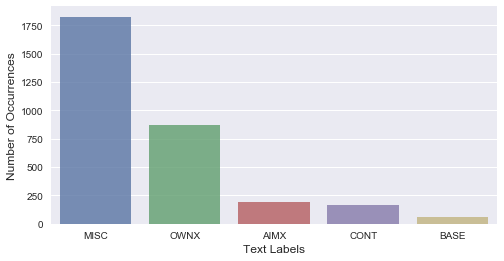

In [24]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

count = labeled['labels'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(count.index, count.values, alpha=0.8);
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Text Labels', fontsize=12)

In [25]:
def check_dist(data):
    Count_OWNX = len(data[data['labels']=='OWNX'])
    Count_AIMX = len(data[data['labels']=='AIMX'])
    Count_CONT = len(data[data['labels']=='CONT'])
    Count_BASE = len(data[data['labels']=='BASE'])
    Count_MISC = len(data[data['labels']=='MISC'])
    Percent_OWNX = Count_OWNX/(Count_OWNX+Count_AIMX+Count_CONT+Count_BASE+Count_MISC)*100
    Percent_AIMX = Count_AIMX/(Count_OWNX+Count_AIMX+Count_CONT+Count_BASE+Count_MISC)*100
    Percent_CONT = Count_CONT/(Count_OWNX+Count_AIMX+Count_CONT+Count_BASE+Count_MISC)*100
    Percent_BASE = Count_BASE/(Count_OWNX+Count_AIMX+Count_CONT+Count_BASE+Count_MISC)*100
    Percent_MISC = Count_MISC/(Count_OWNX+Count_AIMX+Count_CONT+Count_BASE+Count_MISC)*100
    print('The Distribution of labels: \nOWNX: {:.2f}% \nAIMX: {:.2f}% \nCONT: {:.2f}% \nBASE: {:.2f}% \nMISC: {:.2f}%'.format(Percent_OWNX, Percent_AIMX, Percent_CONT, Percent_BASE, Percent_MISC))

# check distribution in number of percentage for labeled
print('Distribusion for labeled')
check_dist(labeled)

# check distribution in number of percentage for labeled
print('Distribusion for labeled3')
check_dist(labeled3)

Distribusion for labeled
The Distribution of labels: 
OWNX: 27.81% 
AIMX: 6.22% 
CONT: 5.45% 
BASE: 1.96% 
MISC: 58.56%
Distribusion for labeled3
The Distribution of labels: 
OWNX: 27.91% 
AIMX: 6.16% 
CONT: 4.33% 
BASE: 1.44% 
MISC: 60.15%


The data is imbalanced, we will use stratified k fold to fix this.

## 3.2 Frequency Distribution Plot

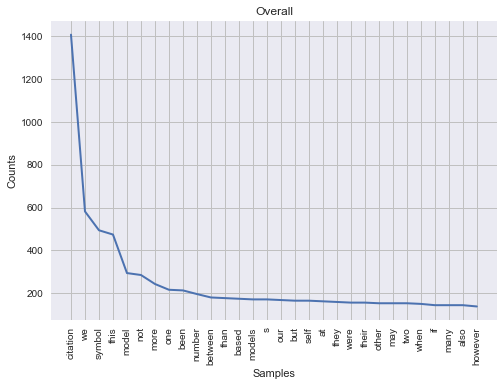

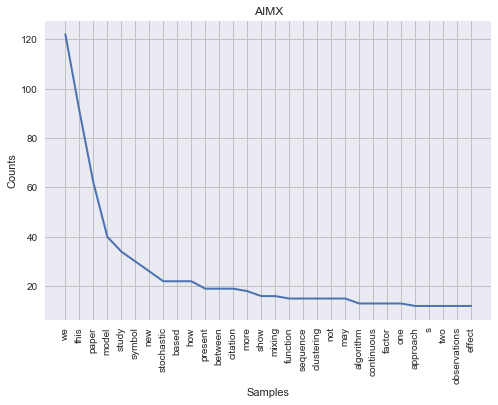

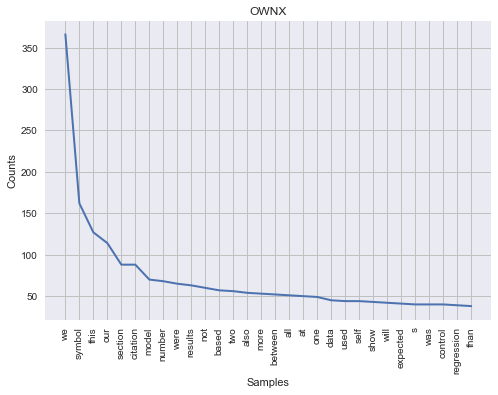

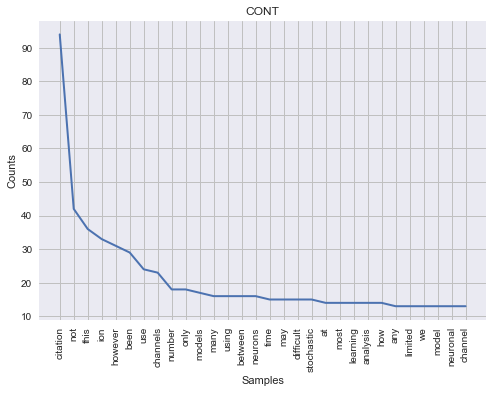

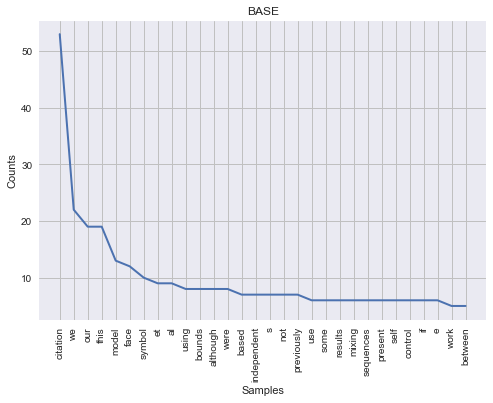

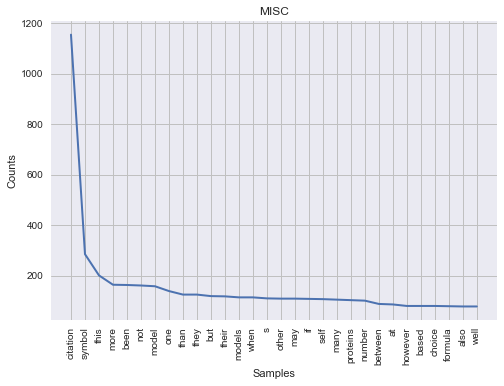

In [26]:
aimx = labeled.loc[labeled['labels'] == 'AIMX']
ownx = labeled.loc[labeled['labels'] == 'OWNX']
cont = labeled.loc[labeled['labels'] == 'CONT']
base = labeled.loc[labeled['labels'] == 'BASE']
misc = labeled.loc[labeled['labels'] == 'MISC']

aimx_t = aimx.text_cleaned
ownx_t = ownx.text_cleaned
cont_t = cont.text_cleaned
base_t = base.text_cleaned
misc_t = misc.text_cleaned

# plot frequencies
fd = nltk.FreqDist([y for x in labeled.text_cleaned.str.split() for y in x])

fd_aimx = nltk.FreqDist([y for x in aimx_t.str.split() for y in x])
fd_ownx = nltk.FreqDist([y for x in ownx_t.str.split() for y in x])
fd_cont = nltk.FreqDist([y for x in cont_t.str.split() for y in x])
fd_base = nltk.FreqDist([y for x in base_t.str.split() for y in x])
fd_misc = nltk.FreqDist([y for x in misc_t.str.split() for y in x])

fd.plot(30, title='Overall')

fd_aimx.plot(30, title='AIMX')
fd_ownx.plot(30, title='OWNX')
fd_cont.plot(30, title='CONT')
fd_base.plot(30, title='BASE')
fd_misc.plot(30, title='MISC')

## 3.3 Wordclouds

Print the word cloud to visualize the top words frequency.

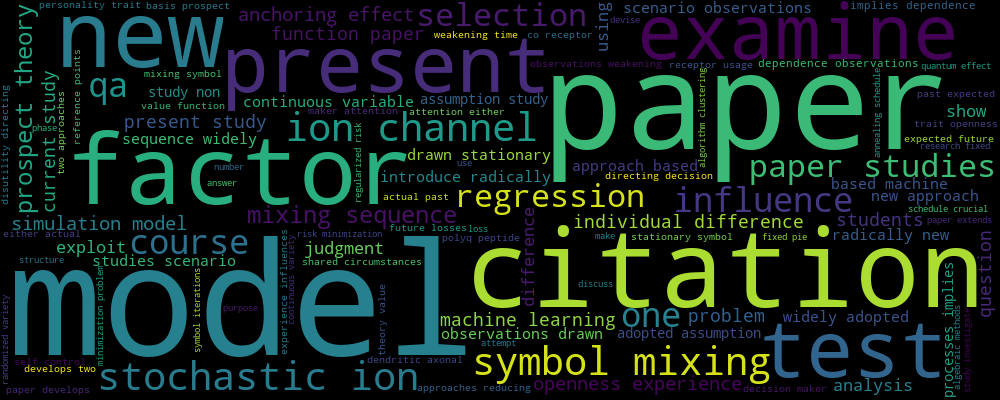

In [27]:
# AIMX

sns.set_style({'axes.grid' : False})
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(aimx_t)).to_image()

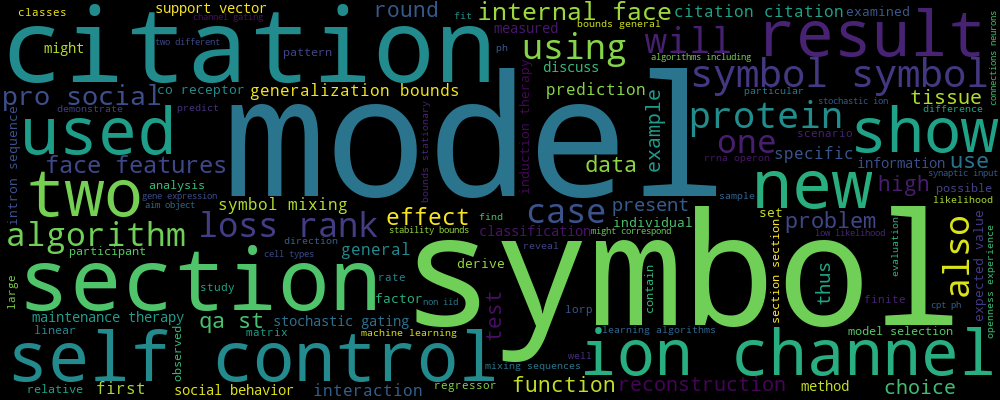

In [28]:
# OWnx
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(ownx_t)).to_image()

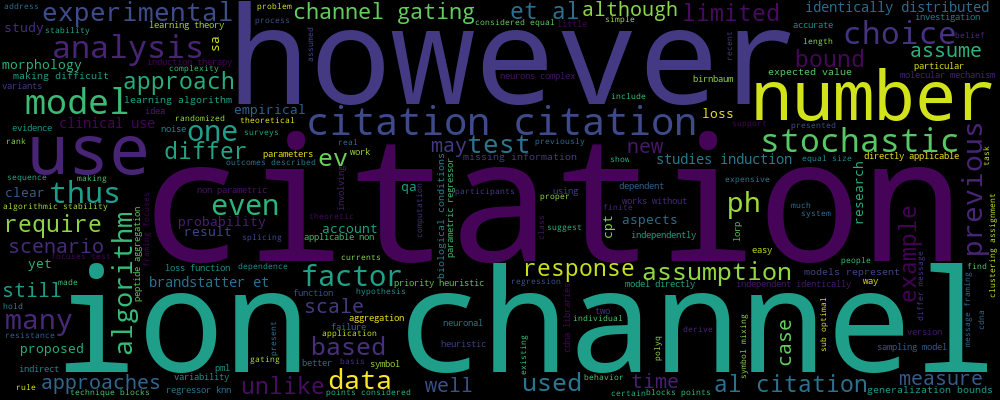

In [29]:
# Cont
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(cont_t)).to_image()

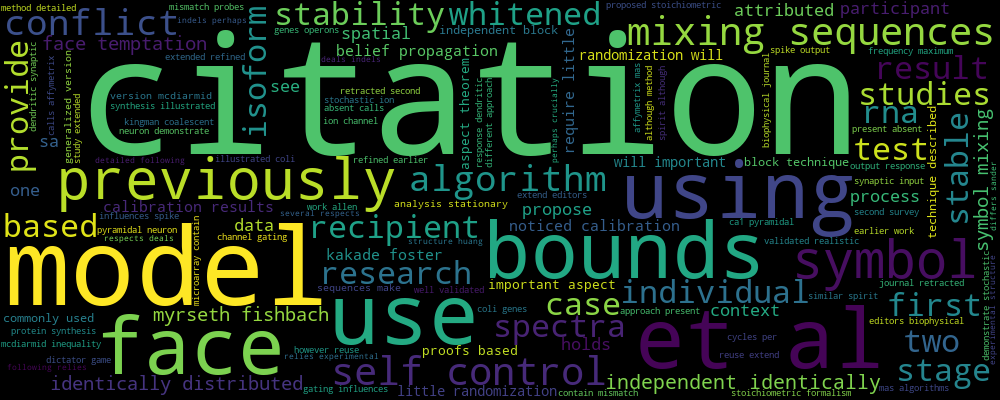

In [30]:
# Base
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(base_t)).to_image()

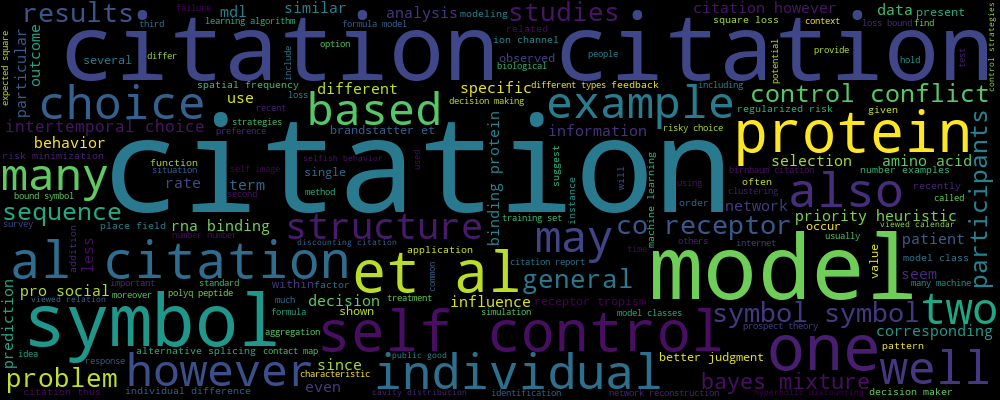

In [31]:
# MISC
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(misc_t)).to_image()

**Removing more words?**

Several labels have many words overlapped. Example Citation in Base and Misc, Model in OWNX, AIMX and CONT. This may result in low accuracy in modeling. Let's reprocess it by also removing the overlaps words.

In [32]:
# x_y_overlaps are words that overlap in dictionary['x'] and dictionary['y']
aim_own_overlaps = [w for w in dictionary['aim'] if w in dictionary['own']]
aim_cont_overlaps =  [w for w in dictionary['aim'] if w in dictionary['contrast']]
aim_base_overlaps =  [w for w in dictionary['aim'] if w in dictionary['base']]
cont_base_overlaps = [w for w in dictionary['aim'] if w in dictionary['base']]
overlapwords = aim_own_overlaps + aim_cont_overlaps + aim_base_overlaps + cont_base_overlaps
stopwords2 = dictionary['stopwords'] + overlapwords

# remove duplicates
stopwords2 = list(set(stopwords2))
print(stopwords2)

['new', 'which', 'or', 'are', 'give', 'as', 'of', 'have', 'is', 'we', 'show', 'can', 'these', 'on', 'suggest', 'and', 'that', 'such', 'study', 'for', 'by', 'answer', 'propose', 'be', 'to', 'it', 'discuss', 'the', 'in', 'paper', 'a', 'with', 'work', 'this', 'model', 'was', 'has', 'approach', 'compare', 'an', 'developed', 'present', 'from']


C:\Users\LW130003\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


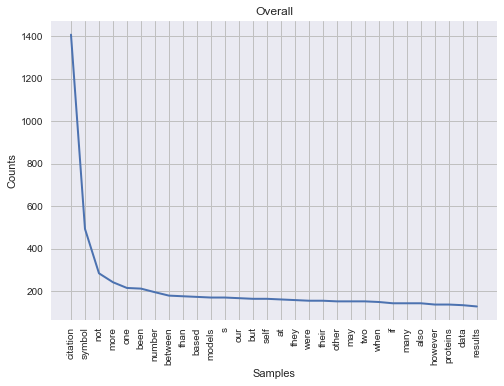

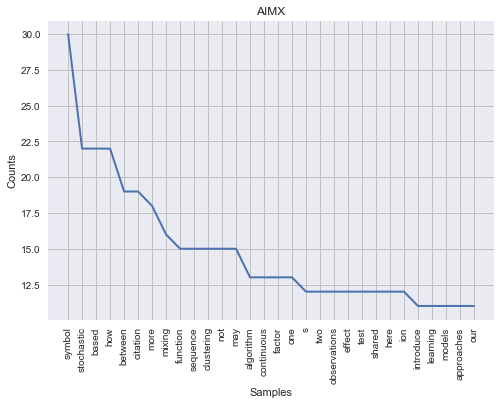

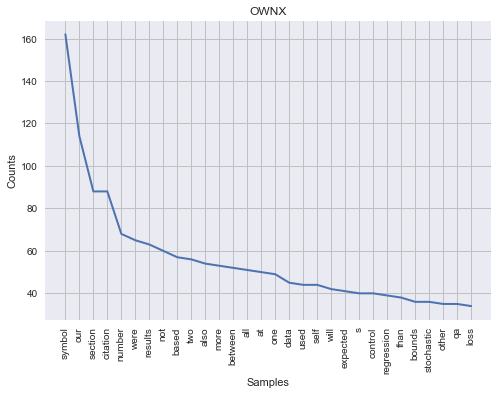

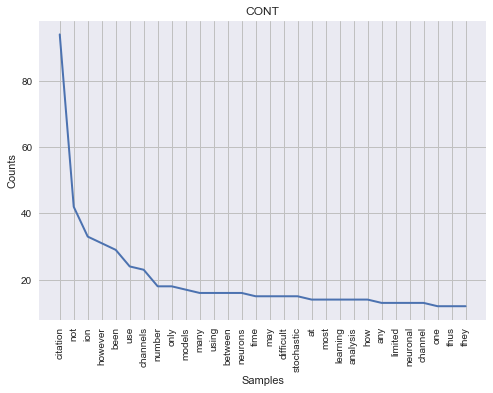

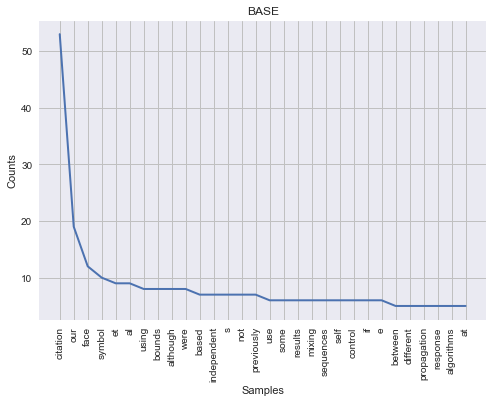

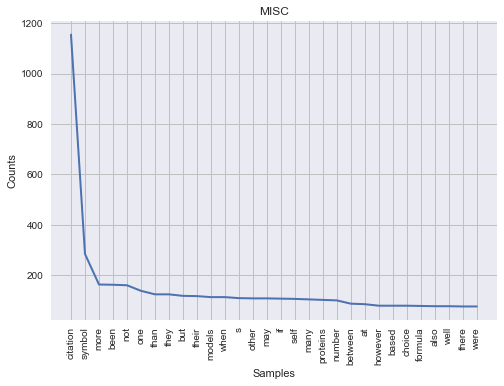

In [33]:
labeled2 = preprocess(labeled, stopwords2)
unlabeled2 = preprocess(unlabeled, stopwords2)

aimx = labeled2.loc[labeled2['labels'] == 'AIMX']
ownx = labeled2.loc[labeled2['labels'] == 'OWNX']
cont = labeled2.loc[labeled2['labels'] == 'CONT']
base = labeled2.loc[labeled2['labels'] == 'BASE']
misc = labeled2.loc[labeled2['labels'] == 'MISC']

aimx_t = aimx.text_cleaned
ownx_t = ownx.text_cleaned
cont_t = cont.text_cleaned
base_t = base.text_cleaned
misc_t = misc.text_cleaned

# plot frequencies
fd = nltk.FreqDist([y for x in labeled2.text_cleaned.str.split() for y in x])

fd_aimx = nltk.FreqDist([y for x in aimx_t.str.split() for y in x])
fd_ownx = nltk.FreqDist([y for x in ownx_t.str.split() for y in x])
fd_cont = nltk.FreqDist([y for x in cont_t.str.split() for y in x])
fd_base = nltk.FreqDist([y for x in base_t.str.split() for y in x])
fd_misc = nltk.FreqDist([y for x in misc_t.str.split() for y in x])

fd.plot(30, title='Overall')

fd_aimx.plot(30, title='AIMX')
fd_ownx.plot(30, title='OWNX')
fd_cont.plot(30, title='CONT')
fd_base.plot(30, title='BASE')
fd_misc.plot(30, title='MISC')

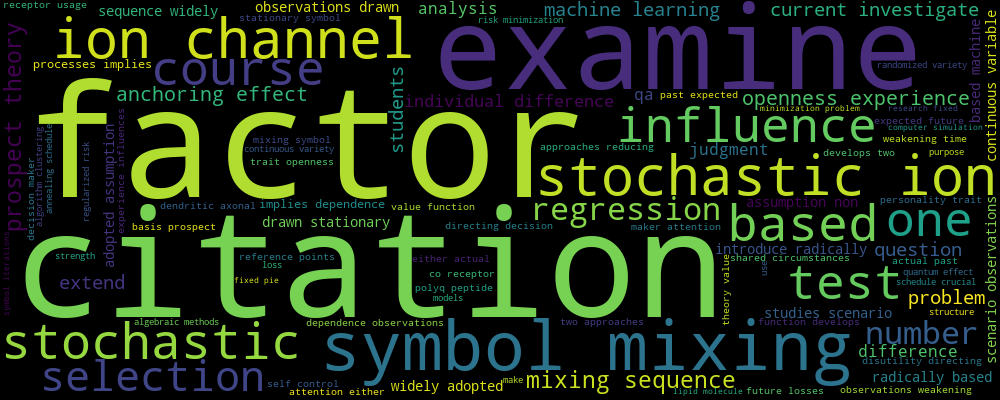

In [34]:
# plot wordcloud
# AIMX
sns.set_style({'axes.grid' : False})
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(aimx_t)).to_image()

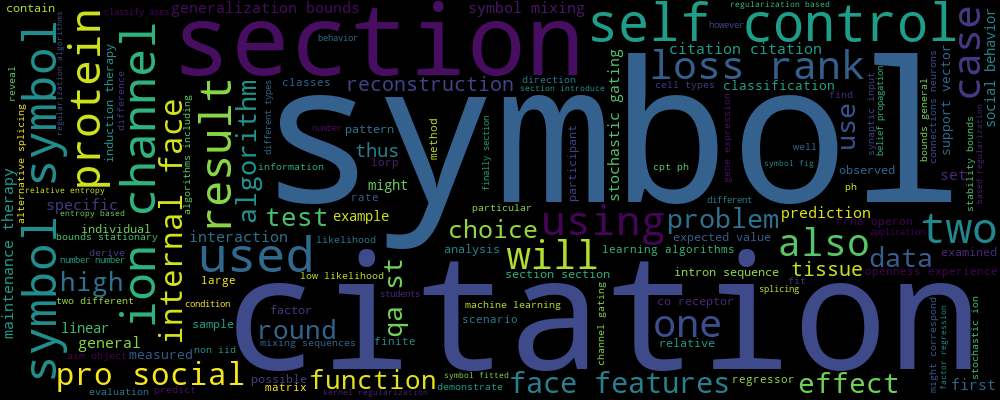

In [35]:
# OWNX
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(ownx_t)).to_image()

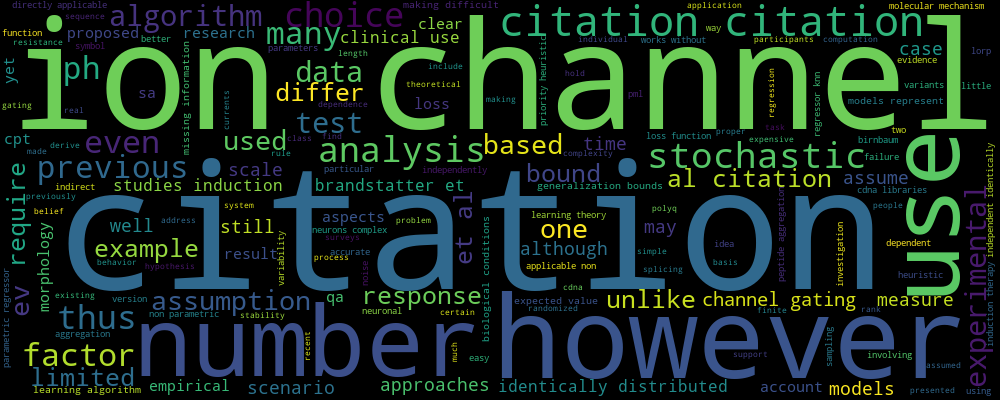

In [36]:
# CONT
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(cont_t)).to_image()

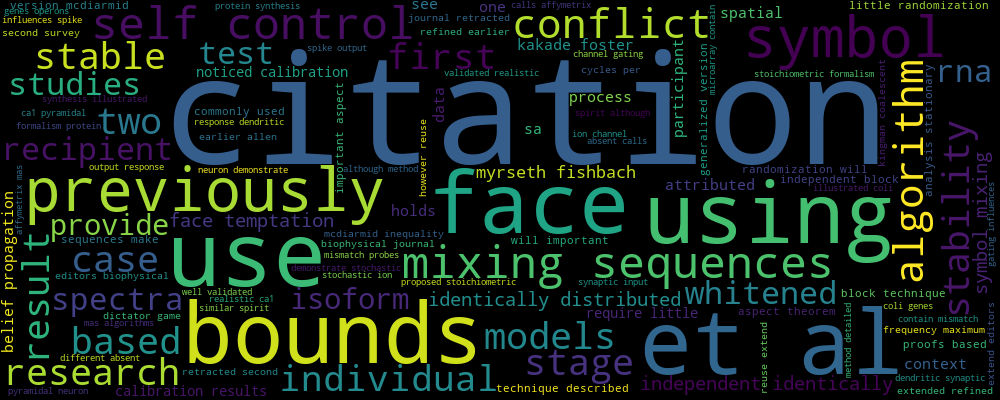

In [37]:
# BASE
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(base_t)).to_image()

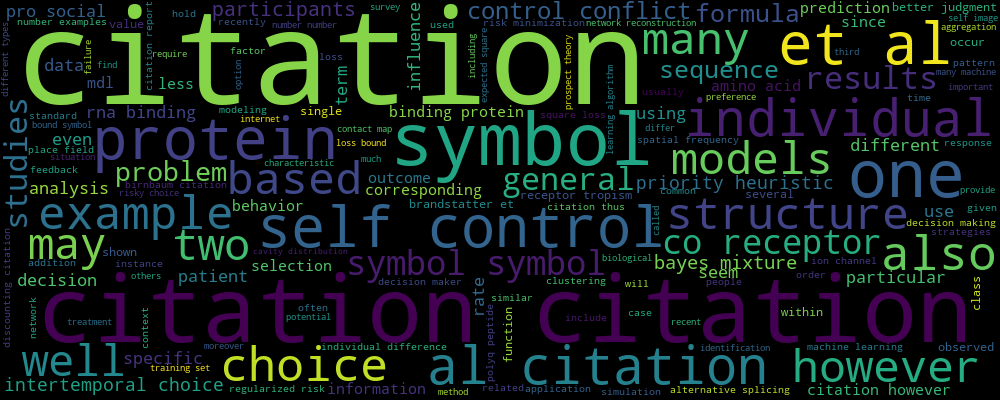

In [38]:
# MISC
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(misc_t)).to_image()

## 3.4 Meta-features distribution

In [39]:
sns.set()
import matplotlib.pyplot as plt

def drop_outliers(s):
    # this function is used to drop outliers.
    # outliers is assumed outside the std range
    m = s.mean()
    std = s.std()
    return s[(m - 3*std <= s) & (s <= m + 3*std)]

def plot_metafeatures(data):
    # this function plot metafeatures
    metafeatures = ['num_words', 'num_unique_words', 'num_chars', 'num_punctuations', 
        'num_words_upper', 'mean_word_len']
    for meta in metafeatures:
        f, ax = plt.subplots(figsize=(7,4))
        sns.kdeplot(drop_outliers(aimx[meta]), shade=True, color='r')
        sns.kdeplot(drop_outliers(ownx[meta]), shade=True, color='b')
        sns.kdeplot(drop_outliers(cont[meta]), shade=True, color='g')
        sns.kdeplot(drop_outliers(base[meta]), shade=True, color='w')
        sns.kdeplot(drop_outliers(misc[meta]), shade=True, color='y')
        ax.legend(labels=['AIMX', 'OWNX', 'CONT', 'BASE', 'MISC'])
        ax.set_title(meta);

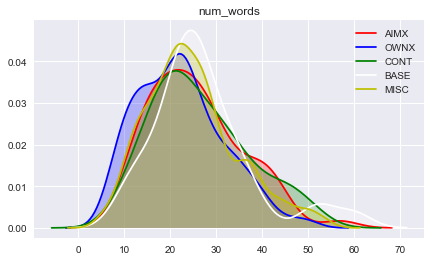

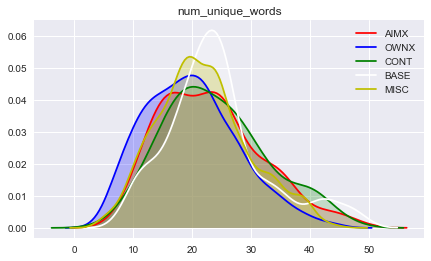

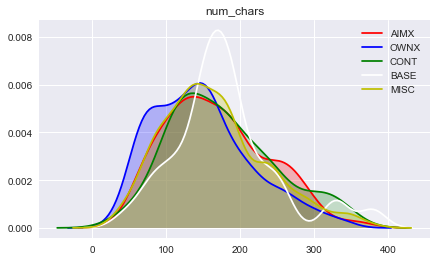

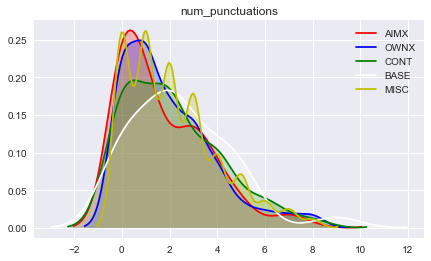

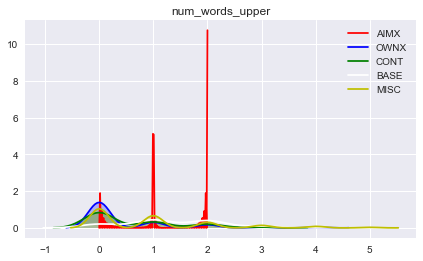

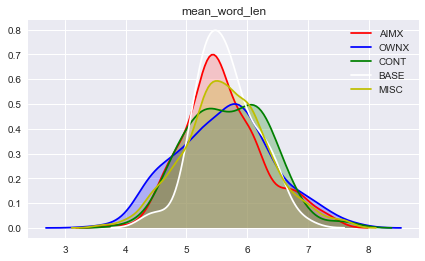

In [40]:
# plot metafeatures in labeled data set
plot_metafeatures(labeled)

# 4. Decision Tree Attempts

According to 'The Labeling Procedure' section in 'Instructions for Labeling sentences.pdf' the labels in scientific articles are labeled with decision trees. Let's try recreating this decision tree.

## 4.1 Decision Tree in Intructions for Labeling Sentences.pdf

Because the dictionary does not have words to check general situation. I modify the tree to the following picture.

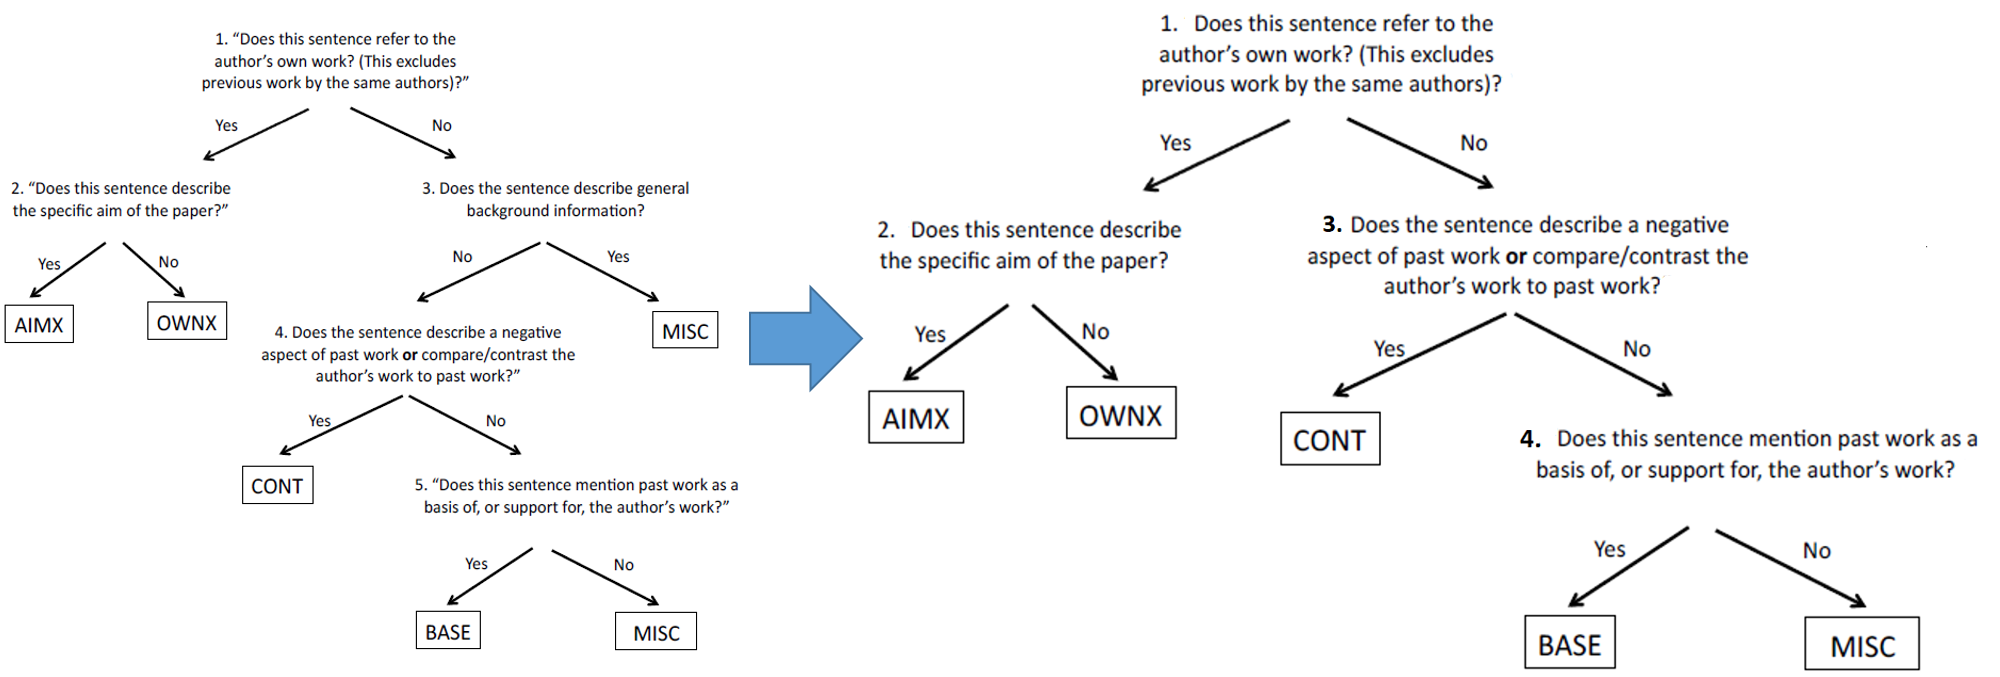

In [41]:
from IPython.display import Image
img = 'dectree.png'
Image(filename=img)

In [42]:
def compute_metric(data):
    # Calculate accuracy percentage
    # actual = 'labels', predicted = 'Predictions'
    data = data.reset_index(drop=True)
    actual = data['labels']
    predicted = data['Predictions']
    
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    accuracy = correct / float(len(actual)) * 100.0
    print('Accuracy: {}'.format(accuracy))
        
    return accuracy

def split_tree(data, dictionary, no):
    # this function split the dataframe to 2: rows that satisfy the question and not satisfy the question
    # input: - dataframe,
    # - name of columns where the text is
    # - dictionary that will be used
    # - no of question that will be asked
    
    # out: return true tree, false tree
    
    # List of questions
    # Q1. Is in Own?
    # Q2. Is in Aim?
    # Q3. Is in Cont?
    # Q4. Is in Base?

    lst = ['own', 'aim', 'contrast', 'base']
    dictionary = dictionary[lst[no-1]]   
    idx = [False]*data.shape[0]
    data_idx = data.index.tolist()
    
    for i, word0 in enumerate(data.text_cleaned):
        # turn string into list of words
        word0 = re.sub("[^\w]"," ",word0).split()
        for word1 in word0:
            for word2 in dictionary:
                if word1 == word2:
                    idx[i] = True
    
    # flip boolean
    not_idx = [not i for i in idx]

    true_tree = data[idx]
    false_tree = data[not_idx]    
                
    return true_tree, false_tree

def DTNotes(data, dictionary):
    # input: - dataframe
    # - name of column where the text is
    # - dictionary that will be used
    # we will follow the same construction as the picture
    
    # Q1. Is it Own?
    true_tree_1, false_tree_1 = split_tree(data, dictionary, 1)
    
    # Q2. Is it Aim?
    true_tree_2, false_tree_2 = split_tree(true_tree_1, dictionary, 2)
    
    # Q3. Is it Cont?
    true_tree_3, false_tree_3 = split_tree(false_tree_1, dictionary, 3)
    
    # Q4. Is it Base?
    true_tree_4, false_tree_4 = split_tree(false_tree_3, dictionary, 4)
    
    # predictions - put label predictions to each decision tree
    AIMX = pd.DataFrame('AIMX', columns=['Predictions'], index=true_tree_2.index)
    true_tree_2 = pd.concat([true_tree_2, AIMX], axis=1)#, join_axes=[true_tree_2.index])

    OWNX = pd.DataFrame('OWNX', columns=['Predictions'], index=false_tree_2.index)
    false_tree_2 = pd.concat([false_tree_2, OWNX], axis=1)#, join_axes=[false_tree_2.index])
    
    CONT = pd.DataFrame('CONT', columns=['Predictions'], index=true_tree_3.index)
    true_tree_3 = pd.concat([true_tree_3, CONT], axis=1)#, join_axes=[true_tree_3.index])

    BASE = pd.DataFrame('BASE', columns=['Predictions'], index=true_tree_4.index)
    true_tree_4 = pd.concat([true_tree_4, BASE], axis=1)#, join_axes=[true_tree_4.index])
    
    MISC = pd.DataFrame('MISC', columns=['Predictions'], index=false_tree_4.index)
    false_tree_4 = pd.concat([false_tree_4, MISC], axis=1)#, join_axes=[false_tree_4.index])
    
    data = pd.concat([true_tree_2, false_tree_2, true_tree_3, true_tree_4, false_tree_4])
    
    accuracy = compute_metric(data)

    return data, accuracy

In [43]:
test1 = DTNotes(labeled, dictionary)

Accuracy: 39.063502245028864


In [44]:
test1 = DTNotes(labeled2, dictionary)

Accuracy: 39.063502245028864


The accuracy is very low which implies the model is inaccurate. Let's try creating the tree from scratch by computing Gini Impurities and Information Gain.

## 4.2 Decision Tree from Scratch
To build a decision tree we need to know which question to ask and when. To do that we need to quantify how much a question helps us in unimixing the label.

Gini impurity is a measure how much uncertainity at a single node would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.

Information Gain (IG) is a measure how much a question reduce Gini Impurity in a node. IG is the one that decide which feature to split on at each step in building the tree. To keep our tree small, we need to pick questions that reduce our uncertainty the most.

The splitting continues until either all children nodes are pure (gini = 0) or IG is 0.

In [45]:
# function
def gini(rows):
    # this function compute current node impurity
    # input is a data['labels'] of current node
    #count number of each labels and put into dictionary
    counts = rows.value_counts().to_dict()
    total_prob_square = 0
    for label in counts:
        label_prob = counts[label] / float(len(rows))
        total_prob_square = total_prob_square + label_prob**2
    impurity = 1 - total_prob_square
    return impurity

def info_gain(left, right, current_uncertainty):
    # this function compute information gain after splitting
    # information gain = uncertainty of current node - weighted impurity of two child nodes
    # input: left tree (Series), right tree(Series), current uncertainty
    
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

def find_best_split(data):
    # this function find the best question to ask in the current nodes
    # input: dataframe and name of text columns
    current_uncertainty = gini(data['labels'])
    best_gain = 0
    best_question_no = 0
    for i in range(1,5):
        true_tree, false_tree = split_tree(data, dictionary, i)
        ig = info_gain(true_tree['labels'], false_tree['labels'], current_uncertainty)
        if ig >= best_gain:
            best_gain = ig
            best_question_no = i
    
    return best_gain, best_question_no

def class_count(data):
    # count number of each type of example in a dataset
    counts = data['labels'].value_counts().to_dict()
    return counts

class Leaf:
    def __init__(self, data):
        self.predictions = class_count(data)
                
class Decision_Node:
    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch
        
def print_question(q_no):
    source = ['own', 'aim', 'contrast', 'base']
    q_str = 'Is it in ' + source[q_no-1] + ' Dictionary?'
    return q_str
    
def build_tree(data):
    
    gain, question = find_best_split(data)
        
    if gain == 0:
        return Leaf(data)
        
    true_tree, false_tree = split_tree(data, dictionary, question)
        
    # recursively expand true_tree and false_tree
    true_branch = build_tree(true_tree)
    false_branch = build_tree(false_tree)
        
    return Decision_Node(question, true_branch, false_branch)

def print_tree(node, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print(spacing + "Predict", node.predictions)
        return
    
    # Print the question at this node
    print(spacing + print_question(node.question))

    # Call this function recursively on the true branch
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

def isindictionary(text_NLP, question_no):
    question_list = ['own', 'aim', 'contrast', 'base']
    list_of_words = dictionary[question_list[question_no - 1]]
    text_NLP = text_NLP.split()
    isin = False
    for word1 in text_NLP:
        for word2 in list_of_words:
            if word1 == word2:
                isin = True
    return isin
        
def predict(text_NLP, node):
    # base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions
    
    question_no = node.question
    if isindictionary(text_NLP, question_no):
        return predict(text_NLP, node.true_branch)
    else:
        return predict(text_NLP, node.false_branch)
    
test2 = build_tree(labeled)
print_tree(test2)

Is it in own Dictionary?
--> True:
  Is it in contrast Dictionary?
  --> True:
    Is it in aim Dictionary?
    --> True:
      Is it in base Dictionary?
      --> True:
        Predict {'MISC': 7, 'CONT': 5, 'AIMX': 4, 'BASE': 3, 'OWNX': 2}
      --> False:
        Predict {'MISC': 26, 'OWNX': 21, 'CONT': 16, 'AIMX': 9, 'BASE': 6}
    --> False:
      Is it in base Dictionary?
      --> True:
        Predict {'MISC': 18, 'OWNX': 15, 'CONT': 12, 'BASE': 9, 'AIMX': 3}
      --> False:
        Predict {'MISC': 246, 'OWNX': 124, 'CONT': 41, 'AIMX': 17, 'BASE': 5}
  --> False:
    Is it in base Dictionary?
    --> True:
      Is it in aim Dictionary?
      --> True:
        Predict {'MISC': 6, 'BASE': 3, 'OWNX': 3}
      --> False:
        Predict {'MISC': 47, 'OWNX': 32, 'AIMX': 5, 'BASE': 3, 'CONT': 3}
    --> False:
      Is it in aim Dictionary?
      --> True:
        Predict {'OWNX': 53, 'MISC': 28, 'AIMX': 10, 'BASE': 5, 'CONT': 3}
      --> False:
        Predict {'OWNX': 332, 'MIS

# 5. Imabalanced Multi-Class Problem

Based on plot in section 3.3, we plot it again below. This is most likely an imbalanced data problem. In this section, we will vectorize the text and apply machine learning algorithm from sklearn. 

Whether we used all data or only from annotator 3, it could be observed the data is totally imbalanced. We need to resampling the data.

For this part, we will only use NaiveBayes as it is faster and easy to understand. Random Forest, XGBoost will be used in later parts.

Imbalanced data problem is a classification problem where the classes are not represent equaly. According to machinelearningmastery. There are 8 ways to solve this problem:
1. Collect more data
2. Changing your performance metric
3. Resampling the dataset
4. Generate synthetic samples
5. Try different algorithm
6. Try Penalized model
7. Try a different perspective
8. Try getting creative

In this exercise we will try to resample the data set and generate synthetic samples. we will also change the data. Then use several machine learning model to test: Naive Bayes, Decision Tree, Random Forest and XGBoost.

**Different Accuracy Metrics**
- **Accuracy** = (TP+TN)/Total
- **Precision** = TP/(TP+FP)
- **Recall** = TP/(TP+FN)
- **TP** = True positive = number of positive cases which are predicted positive
- **TN** = True negative = number of negative cases which are predicted negative
- **FP** = False positive = number of negative cases which are predicted positive
- **FN** = False positive = number of positive cases which are predicted negative

We are going to:
1. Undersampling - randomly downsamples the majority class.
2. Oversampling - randomly replicates minority instances to increase their population
3. SMOTE - synthetically create new sample to increase minority's population

Note: some think that oversampling is superior because it results in more data, whereas undersampling throws away the data. but keep in mind that replicating data is not without consequence - since it results in duplicate data, it makes variables appear to have lower variance than they do. The positive consequence is that it duplicates the number of errors: If a classifier makes a false neative error on the original minority data set, and that data set is replicated five times, the classifier will make six errors on the new set. Conversely, undersampling can make the independent variables look like they have a higher variance than they do.

In [46]:
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.metrics import confusion_matrix, recall_score, precision_recall_curve 
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 5.1 No Resampling

In [47]:
# One Hot Encoding
# this function One-Hote Encoding the data. It maps values in 3 dictionary below
remap2 = {'abstract': 0, 'introduction': 1}
remap3 = {'arxiv': 0, 'jdm': 1, 'plos': 2}

# labeled['labels'].replace(remap1, inplace=True)
labeled['type'].replace(remap2, inplace=True)
labeled['domain'].replace(remap3, inplace=True)

unlabeled['type'].replace(remap2, inplace=True)
unlabeled['domain'].replace(remap3, inplace=True)

In [52]:
# vectorizer
tfidf_vec1 = TfidfVectorizer(min_df=0, ngram_range=(1,1))
tfidf_vec2 = TfidfVectorizer(min_df=0, ngram_range=(1,2))
tfidf_vec3 = TfidfVectorizer(min_df=0, ngram_range=(1,3))

count_vec1 = CountVectorizer(min_df=0, ngram_range=(1,1))
count_vec2 = CountVectorizer(min_df=0, ngram_range=(1,2))
count_vec3 = CountVectorizer(min_df=0, ngram_range=(1,3))

vectorizers_count = [count_vec1, count_vec2, count_vec3]
vectorizers_tfidf = [tfidf_vec1, tfidf_vec2, tfidf_vec3]

In [61]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    ### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def text_model(estimator, vectorizer, train, test, plot = True, cv=5):
    """ 
    This function vectorize text, train, predict and evaluate model
    This function does not include metadata
    input: 
        - estimator - ML algorithm we use
        - vectorizer - text vectorizen we use
        - train - labeled data
        - test - unlabeled data
        - plot - plot confusion matrix (True: plot, False: not plot)
    note: the labels must be numeric, unlike text_model
    """
    #train_X = train_df.drop(cols_to_drop+['labels'], axis=1)
    #test_X = test_df.drop(cols_to_drop, axis=1)
           
    # Vectorizes the text_cleaned
    data = train['text_cleaned'].append(test['text_cleaned'])
    full_vec = vectorizer.fit_transform(data)
    train_vec = vectorizer.transform(train['text_cleaned']) # vectorize training set
    test_vec = vectorizer.transform(test['text_cleaned']) # vectorize test set
    z = train['labels'] # target values
    
    # One Hot Encoding
    remap1 = {'OWNX': 0, 'AIMX': 1, 'CONT': 2, 'BASE': 3, 'MISC': 4}
    y = z.replace(remap1)
    
    # Cross-validation    
    cv_scores = []
    pred_train = np.zeros([train.shape[0],5])
    skf = StratifiedKFold(n_splits = cv, shuffle=True, random_state=2018)
    pred_full_test = 0
    
    for dev_idx, val_idx in skf.split(train_vec, y):
        # split train and test into training and validation sets
        # training sets: training, target_training
        # validation sets: valid, target_valid
        training, valid = train_vec[dev_idx], train_vec[val_idx]
        target_training, target_valid = y[dev_idx], y[val_idx]
        
        # fit the model
        estimator.fit(training, target_training)
        # predict validation set
        pred_valid = estimator.predict_proba(valid)        
        pred_test = estimator.predict_proba(test_vec)
        pred_full_test = pred_full_test + pred_test
        pred_train[val_idx, :] = pred_valid
        cv_scores.append(log_loss(target_valid, pred_valid))       
        
    print('Mean CV LogLoss: {:.3f}'.format(np.mean(cv_scores)))
    pred_full_test = np.round(pred_full_test / cv)

    # np.argmax(pred_val)
    if plot == True:
        # plot confusion matrix
        cnf_matrix = confusion_matrix(target_valid, np.argmax(pred_valid, axis=1))
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure(figsize=(8,8))
        plot_confusion_matrix(cnf_matrix, classes=['OWNX', 'AIMX', 'CONT', 'BASE', 'MISC'], 
                              normalize = True, title='Confusion matrix, without normalization')
        plt.show()
    
    print(classification_report(target_valid, np.argmax(pred_valid, axis=1)))
    
    return pred_train, pred_full_test

### labeled

Length of training set: 3118
Length of test set: 34595
The Distribution of labels: 
OWNX: 27.81% 
AIMX: 6.22% 
CONT: 5.45% 
BASE: 1.96% 
MISC: 58.56%
count0
Mean CV LogLoss: 2.240


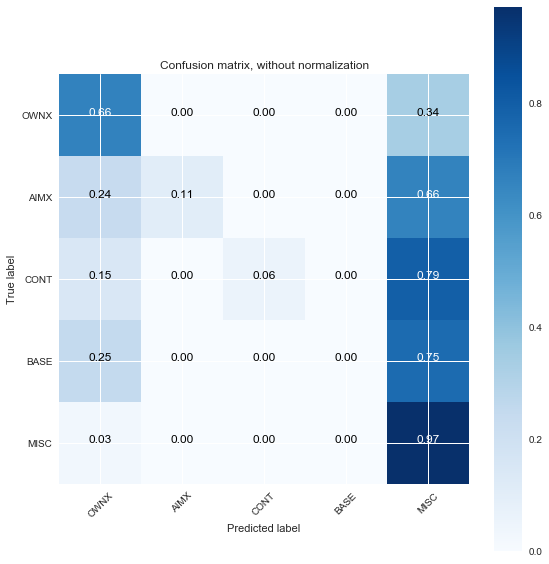

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.81      0.66      0.73       173
          1       1.00      0.11      0.19        38
          2       1.00      0.06      0.11        34
          3       0.00      0.00      0.00        12
          4       0.75      0.97      0.85       365

avg / total       0.78      0.77      0.72       622

tfidf0
Mean CV LogLoss: 0.989


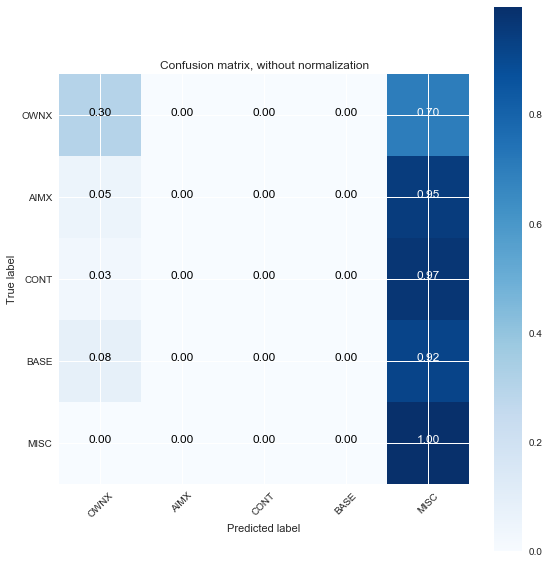

             precision    recall  f1-score   support

          0       0.91      0.30      0.45       173
          1       0.00      0.00      0.00        38
          2       0.00      0.00      0.00        34
          3       0.00      0.00      0.00        12
          4       0.64      1.00      0.78       365

avg / total       0.63      0.67      0.59       622

count1
Mean CV LogLoss: 3.018


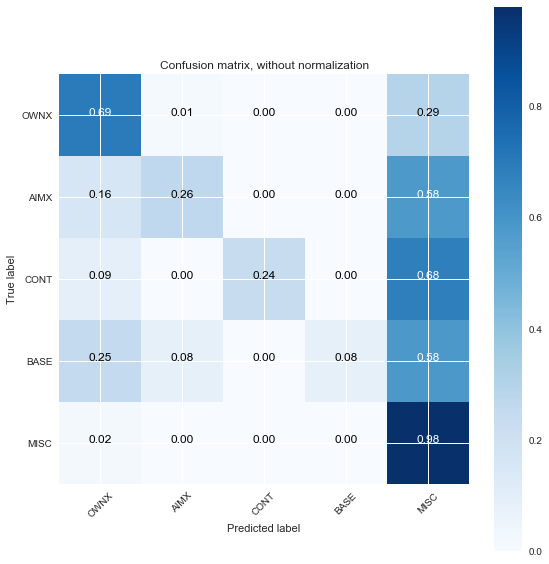

             precision    recall  f1-score   support

          0       0.86      0.69      0.77       173
          1       0.77      0.26      0.39        38
          2       1.00      0.24      0.38        34
          3       1.00      0.08      0.15        12
          4       0.78      0.98      0.87       365

avg / total       0.81      0.80      0.77       622

tfidf1
Mean CV LogLoss: 0.821


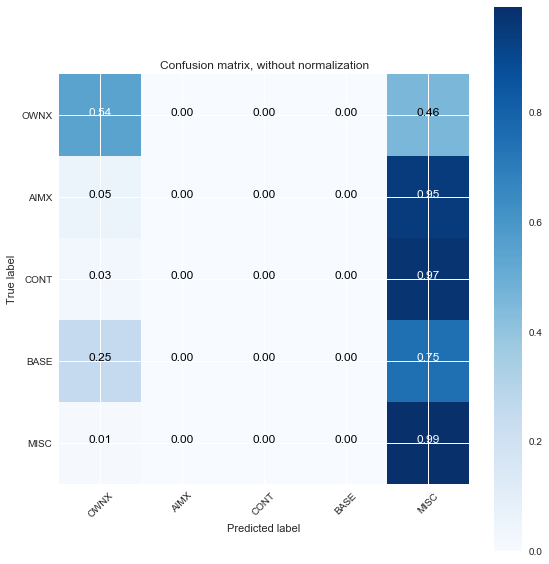

             precision    recall  f1-score   support

          0       0.91      0.54      0.68       173
          1       0.00      0.00      0.00        38
          2       0.00      0.00      0.00        34
          3       0.00      0.00      0.00        12
          4       0.70      0.99      0.82       365

avg / total       0.66      0.73      0.67       622

count2
Mean CV LogLoss: 3.181


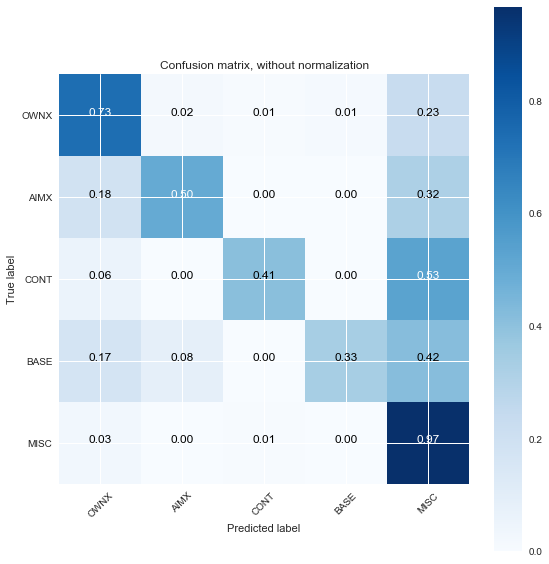

             precision    recall  f1-score   support

          0       0.86      0.73      0.79       173
          1       0.83      0.50      0.62        38
          2       0.82      0.41      0.55        34
          3       0.67      0.33      0.44        12
          4       0.82      0.97      0.89       365

avg / total       0.83      0.83      0.82       622

tfidf2
Mean CV LogLoss: 0.758


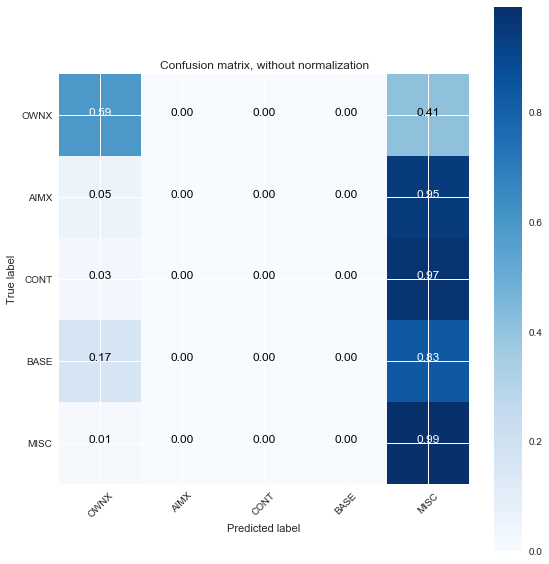

             precision    recall  f1-score   support

          0       0.93      0.59      0.72       173
          1       0.00      0.00      0.00        38
          2       0.00      0.00      0.00        34
          3       0.00      0.00      0.00        12
          4       0.71      0.99      0.83       365

avg / total       0.67      0.75      0.68       622



In [62]:
# MultinomialNB in countVectorizer and tfidfvectorizer
estimator = MultinomialNB()
train = labeled
test = unlabeled
count = dict()
tfidf = dict()

print('Length of training set: {}'.format(train.shape[0]))
print('Length of test set: {}'.format(test.shape[0]))
check_dist(train)
    
for i in range(3):
    # count
    print('count' + str(i))
    vectorizer = vectorizers_count[i]
    count[i] = text_model(estimator, vectorizer, train, test, cv=5)
    # tfidf
    print('tfidf' + str(i))
    vectorizer = vectorizers_tfidf[i]
    tfidf[i] = text_model(estimator, vectorizer, train, test, cv=5)

Based on logloss and predictions results we could see there is something wrong.

### labeled2

Length of training set: 3118
Length of test set: 34595
The Distribution of labels: 
OWNX: 27.81% 
AIMX: 6.22% 
CONT: 5.45% 
BASE: 1.96% 
MISC: 58.56%
count0
Mean CV LogLoss: 2.240


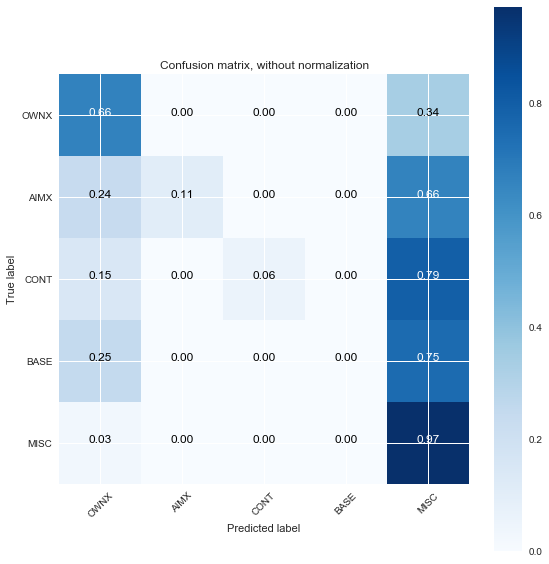

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.81      0.66      0.73       173
          1       1.00      0.11      0.19        38
          2       1.00      0.06      0.11        34
          3       0.00      0.00      0.00        12
          4       0.75      0.97      0.85       365

avg / total       0.78      0.77      0.72       622

tfidf0
Mean CV LogLoss: 0.989


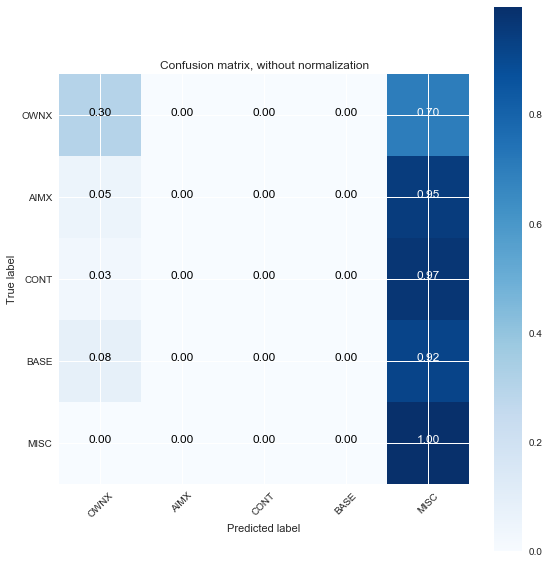

             precision    recall  f1-score   support

          0       0.91      0.30      0.45       173
          1       0.00      0.00      0.00        38
          2       0.00      0.00      0.00        34
          3       0.00      0.00      0.00        12
          4       0.64      1.00      0.78       365

avg / total       0.63      0.67      0.59       622

count1
Mean CV LogLoss: 3.018


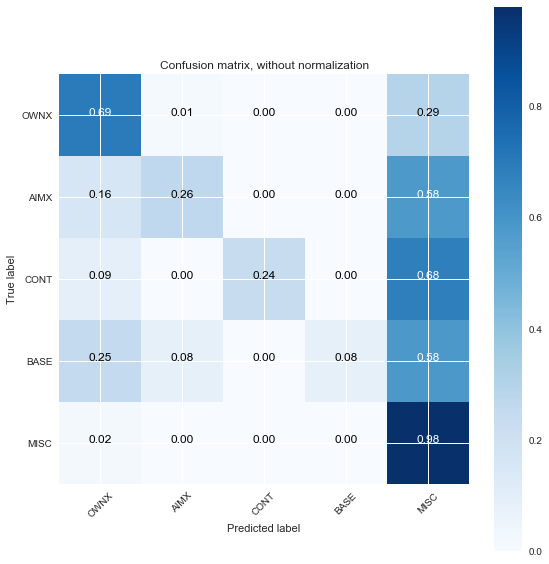

             precision    recall  f1-score   support

          0       0.86      0.69      0.77       173
          1       0.77      0.26      0.39        38
          2       1.00      0.24      0.38        34
          3       1.00      0.08      0.15        12
          4       0.78      0.98      0.87       365

avg / total       0.81      0.80      0.77       622

tfidf1
Mean CV LogLoss: 0.821


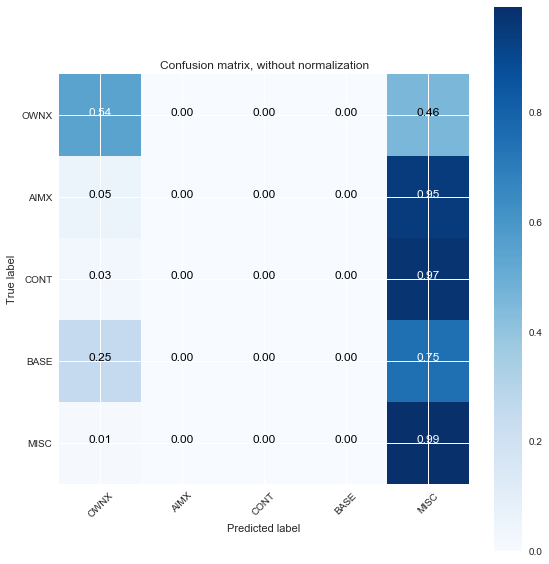

             precision    recall  f1-score   support

          0       0.91      0.54      0.68       173
          1       0.00      0.00      0.00        38
          2       0.00      0.00      0.00        34
          3       0.00      0.00      0.00        12
          4       0.70      0.99      0.82       365

avg / total       0.66      0.73      0.67       622

count2
Mean CV LogLoss: 3.181


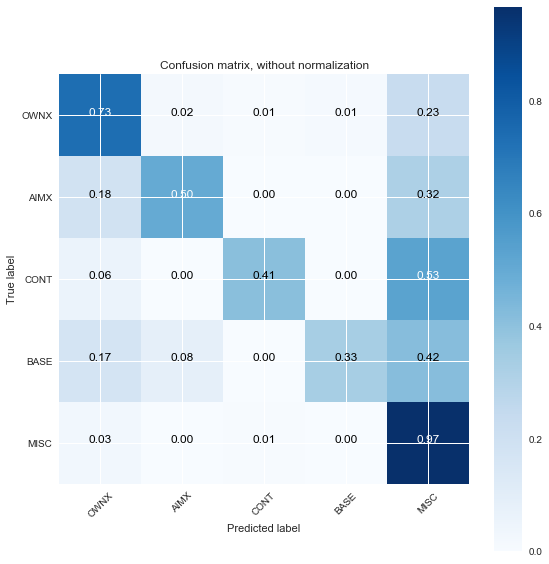

             precision    recall  f1-score   support

          0       0.86      0.73      0.79       173
          1       0.83      0.50      0.62        38
          2       0.82      0.41      0.55        34
          3       0.67      0.33      0.44        12
          4       0.82      0.97      0.89       365

avg / total       0.83      0.83      0.82       622

tfidf2
Mean CV LogLoss: 0.758


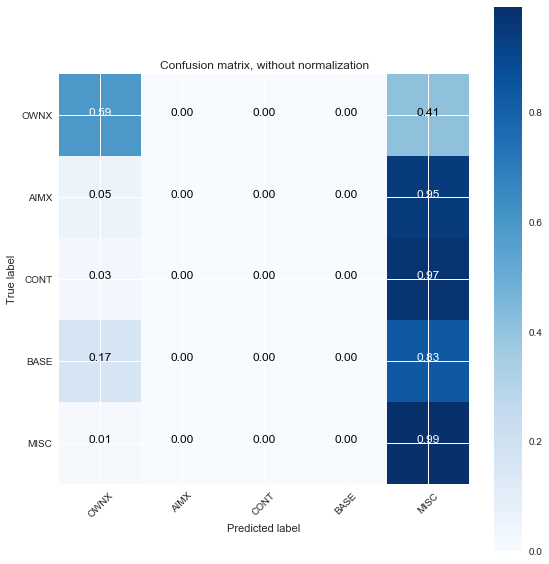

             precision    recall  f1-score   support

          0       0.93      0.59      0.72       173
          1       0.00      0.00      0.00        38
          2       0.00      0.00      0.00        34
          3       0.00      0.00      0.00        12
          4       0.71      0.99      0.83       365

avg / total       0.67      0.75      0.68       622



In [63]:
# MultinomialNB in countVectorizer and tfidfvectorizer
estimator =  MultinomialNB()
train = labeled2
test = unlabeled2
count = dict()
tfidf = dict()

print('Length of training set: {}'.format(train.shape[0]))
print('Length of test set: {}'.format(test.shape[0]))
check_dist(train)

for i in range(3):
    print('count' + str(i))
    vectorizer = vectorizers_count[i]
    count[i] = text_model(estimator, vectorizer, train, test, cv=5)
    print('tfidf' + str(i))
    vectorizer = vectorizers_tfidf[i]
    tfidf[i] = text_model(estimator, vectorizer, train, test, cv=5)

Increasing number of stopwords improve the prediction of minority, but it lower the accuracy. Most likely is because we removed too many keywords.

### Labeled3

Length of training set: 1039
Length of test set: 34595
The Distribution of labels: 
OWNX: 27.91% 
AIMX: 6.16% 
CONT: 4.33% 
BASE: 1.44% 
MISC: 60.15%
count0
Mean CV LogLoss: 3.226


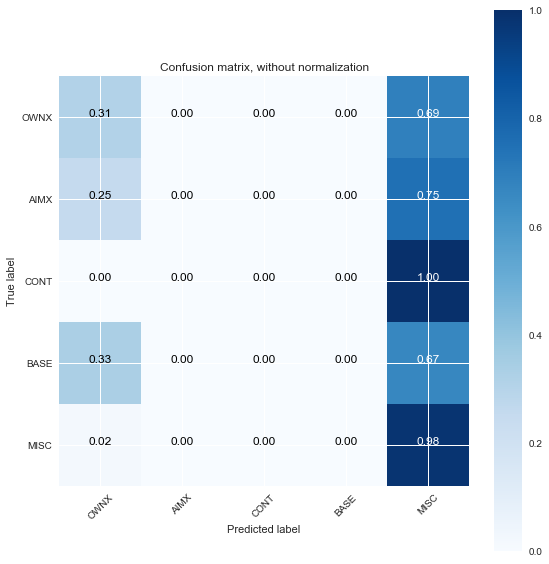

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.75      0.31      0.44        58
          1       0.00      0.00      0.00        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.67      0.98      0.80       125

avg / total       0.62      0.68      0.61       207

tfidf0
Mean CV LogLoss: 1.025


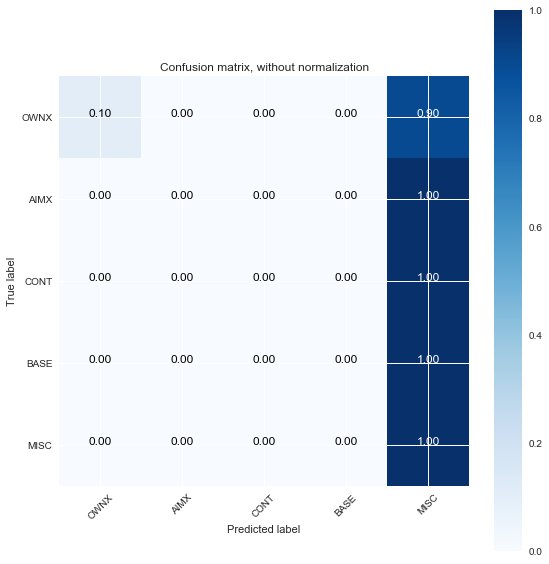

             precision    recall  f1-score   support

          0       1.00      0.10      0.19        58
          1       0.00      0.00      0.00        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.62      1.00      0.77       125

avg / total       0.66      0.63      0.52       207

count1
Mean CV LogLoss: 4.029


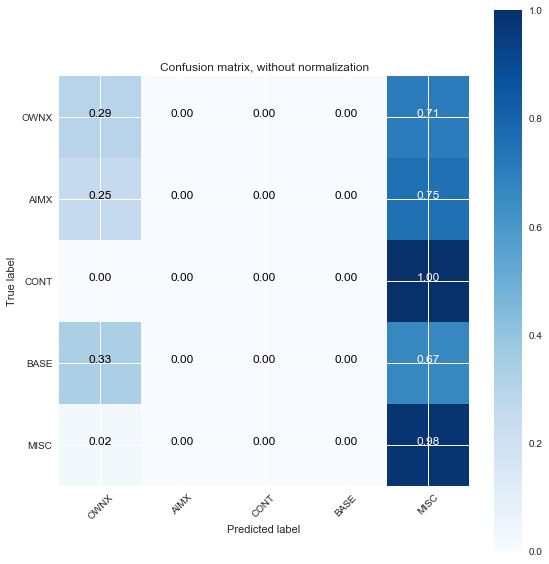

             precision    recall  f1-score   support

          0       0.74      0.29      0.42        58
          1       0.00      0.00      0.00        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.67      0.98      0.80       125

avg / total       0.61      0.68      0.60       207

tfidf1
Mean CV LogLoss: 0.973


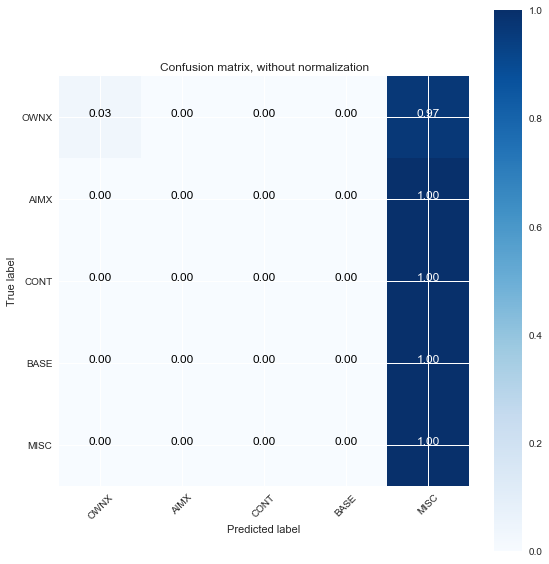

             precision    recall  f1-score   support

          0       1.00      0.03      0.07        58
          1       0.00      0.00      0.00        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.61      1.00      0.76       125

avg / total       0.65      0.61      0.48       207

count2
Mean CV LogLoss: 4.062


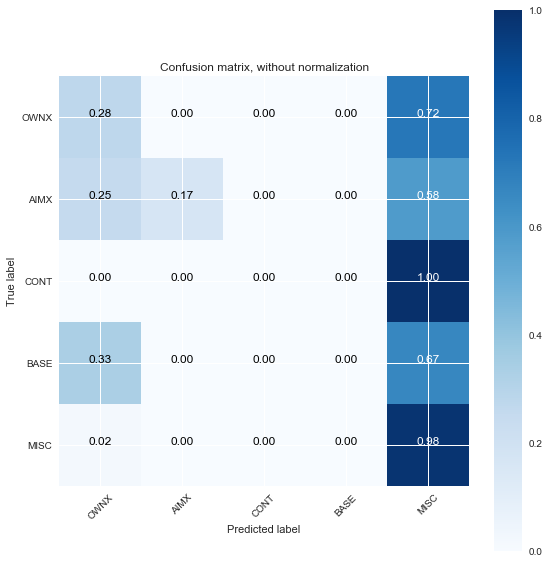

             precision    recall  f1-score   support

          0       0.73      0.28      0.40        58
          1       1.00      0.17      0.29        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.67      0.98      0.80       125

avg / total       0.67      0.68      0.61       207

tfidf2
Mean CV LogLoss: 0.975


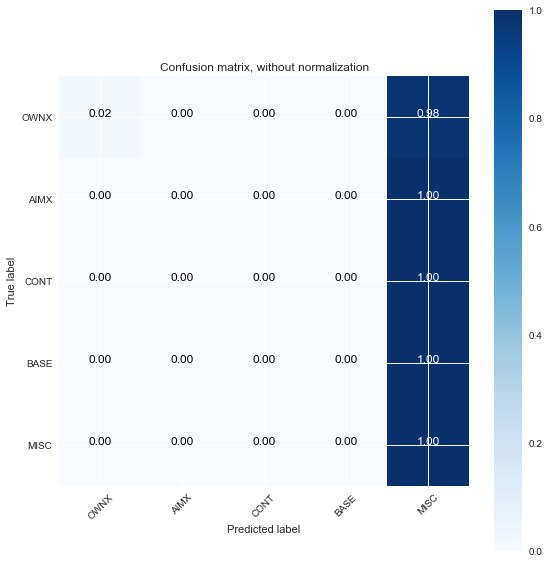

             precision    recall  f1-score   support

          0       1.00      0.02      0.03        58
          1       0.00      0.00      0.00        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.61      1.00      0.76       125

avg / total       0.65      0.61      0.47       207



In [64]:
# Naive Bayes in countVectorizer and tfidfvectorizer
estimator =  MultinomialNB()
train = labeled3
test = unlabeled
count = dict()
tfidf = dict()

print('Length of training set: {}'.format(train.shape[0]))
print('Length of test set: {}'.format(test.shape[0]))
check_dist(train)

for i in range(3):
    print('count' + str(i))
    vectorizer = vectorizers_count[i]
    count[i] = text_model(estimator, vectorizer, train, test, cv=5)
    print('tfidf' + str(i))
    vectorizer = vectorizers_tfidf[i]
    tfidf[i] = text_model(estimator, vectorizer, train, test, cv=5)

## 5.2 Undersampling

Based on the plot let's undersample 'MISC', 'OWNX', 'AIMX', 'CONT'  labels as they dominated the predictions results.

In [65]:
def undersampling(data, prop):
    """
    This function undersample 'MISC' and 'OWNX' labels using 'AIMX' labels as proportion.
    prop is a list [a,b,c] with a -> 'MISC', b -> 'OWNX', c -> 'AIMX'
    For example, [1,1,1] implies number of data with labels 'MISC', 'OWNX' and 'AIMX' are equal
    """
    
    # labels index
    misc_idx = np.array(data[data['labels']=='MISC'].index)
    ownx_idx = np.array(data[data['labels']=='OWNX'].index)
    aimx_idx = np.array(data[data['labels']=='AIMX'].index)
    base_idx = np.array(data[data['labels']=='BASE'].index)
    cont_idx = np.array(data[data['labels']=='CONT'].index)
    
    # count number of 'AIMX' data
    aimx_counts = len(data[data['labels']=='AIMX'])
    
    # set random seed
    np.random.seed(2018)
    
    # randomly pick index
    misc_idx_undersample = np.array(np.random.choice(misc_idx, (prop[0]*aimx_counts), replace=False))
    ownx_idx_undersample = np.array(np.random.choice(ownx_idx, (prop[1]*aimx_counts), replace=False))
    
    # undersample data
    undersample_data = np.concatenate([aimx_idx, base_idx, cont_idx, misc_idx_undersample, ownx_idx_undersample])
    undersample_data = data.iloc[undersample_data,:]
    
    # reset index
    undersample_data.reset_index(drop = True, inplace=True)

    # check undersample_data distribution
    check_dist(undersample_data)
    
    return undersample_data

The Distribution of labels: 
OWNX: 25.40% 
AIMX: 25.40% 
CONT: 17.86% 
BASE: 5.95% 
MISC: 25.40%
The Distribution of labels: 
OWNX: 20.25% 
AIMX: 20.25% 
CONT: 14.24% 
BASE: 4.75% 
MISC: 40.51%
The Distribution of labels: 
OWNX: 33.68% 
AIMX: 16.84% 
CONT: 11.84% 
BASE: 3.95% 
MISC: 33.68%
The Distribution of labels: 
OWNX: 28.83% 
AIMX: 14.41% 
CONT: 10.14% 
BASE: 3.38% 
MISC: 43.24%
Length of training set: 252
Length of test set: 34595
The Distribution of labels: 
OWNX: 25.40% 
AIMX: 25.40% 
CONT: 17.86% 
BASE: 5.95% 
MISC: 25.40%
undersample0 count0
Mean CV LogLoss: 2.037


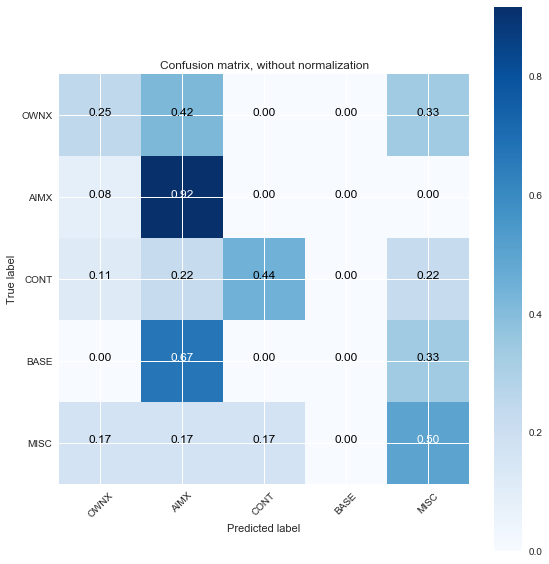

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.43      0.25      0.32        12
          1       0.50      0.92      0.65        12
          2       0.67      0.44      0.53         9
          3       0.00      0.00      0.00         3
          4       0.46      0.50      0.48        12

avg / total       0.47      0.50      0.46        48

undersample0 tfidf0
Mean CV LogLoss: 1.365


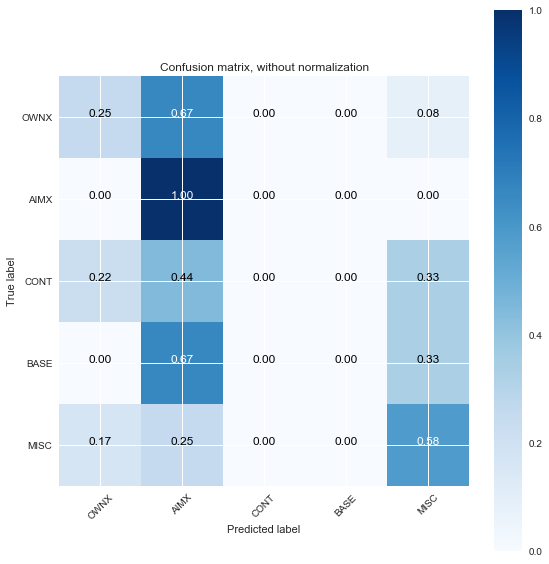

             precision    recall  f1-score   support

          0       0.43      0.25      0.32        12
          1       0.41      1.00      0.59        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.58      0.58      0.58        12

avg / total       0.36      0.46      0.37        48

undersample0 count1
Mean CV LogLoss: 2.346


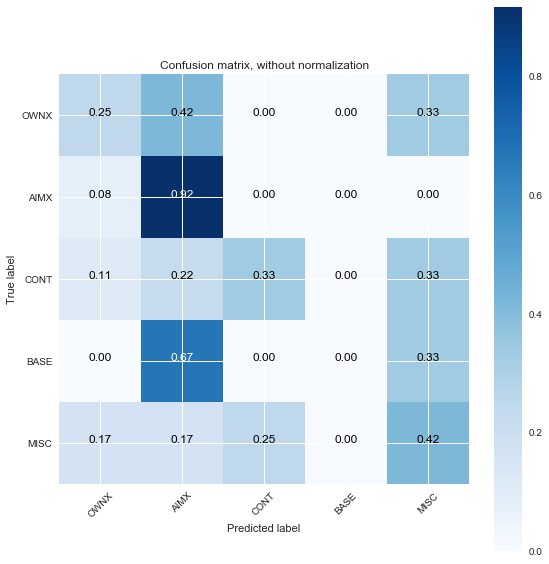

             precision    recall  f1-score   support

          0       0.43      0.25      0.32        12
          1       0.50      0.92      0.65        12
          2       0.50      0.33      0.40         9
          3       0.00      0.00      0.00         3
          4       0.38      0.42      0.40        12

avg / total       0.42      0.46      0.42        48

undersample0 tfidf1
Mean CV LogLoss: 1.412


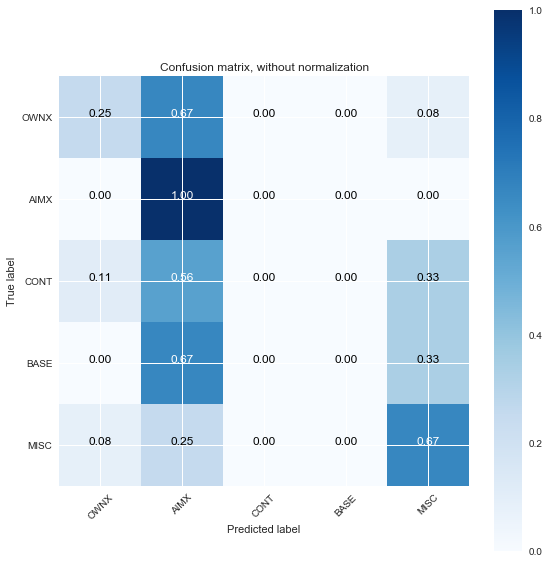

             precision    recall  f1-score   support

          0       0.60      0.25      0.35        12
          1       0.40      1.00      0.57        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.62      0.67      0.64        12

avg / total       0.40      0.48      0.39        48

undersample0 count2
Mean CV LogLoss: 2.457


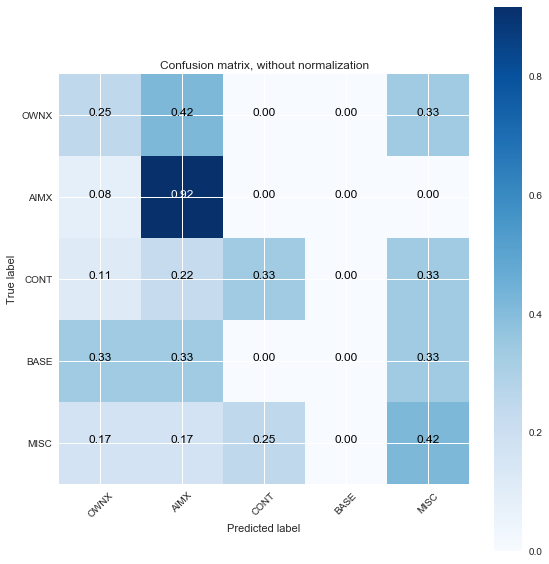

             precision    recall  f1-score   support

          0       0.38      0.25      0.30        12
          1       0.52      0.92      0.67        12
          2       0.50      0.33      0.40         9
          3       0.00      0.00      0.00         3
          4       0.38      0.42      0.40        12

avg / total       0.41      0.46      0.42        48

undersample0 tfidf2
Mean CV LogLoss: 1.440


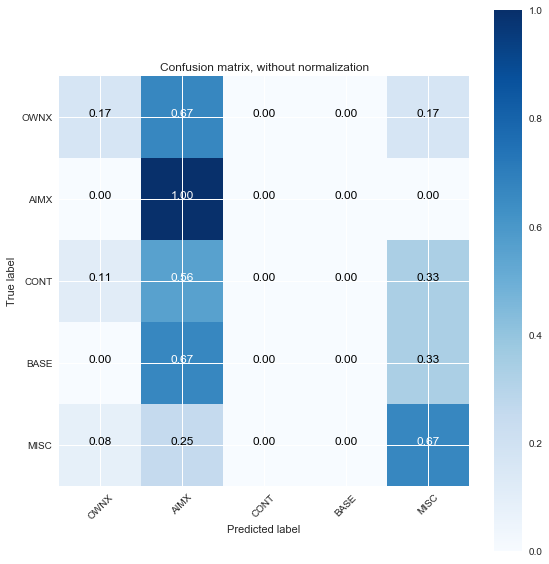

             precision    recall  f1-score   support

          0       0.50      0.17      0.25        12
          1       0.40      1.00      0.57        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.57      0.67      0.62        12

avg / total       0.37      0.46      0.36        48

Length of training set: 316
Length of test set: 34595
The Distribution of labels: 
OWNX: 20.25% 
AIMX: 20.25% 
CONT: 14.24% 
BASE: 4.75% 
MISC: 40.51%
undersample1 count0
Mean CV LogLoss: 2.407


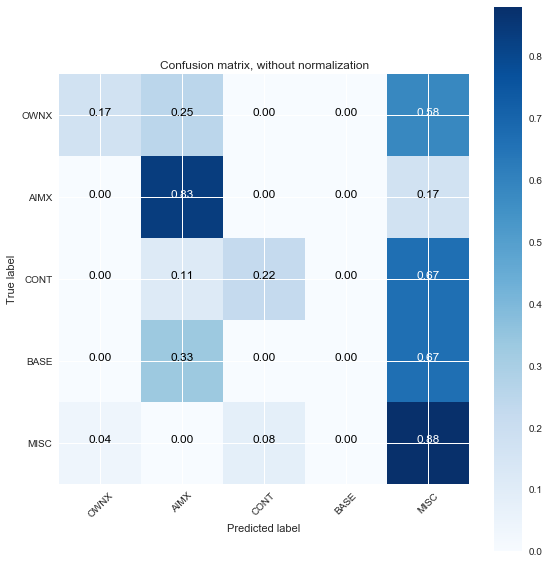

             precision    recall  f1-score   support

          0       0.67      0.17      0.27        12
          1       0.67      0.83      0.74        12
          2       0.50      0.22      0.31         9
          3       0.00      0.00      0.00         3
          4       0.56      0.88      0.69        25

avg / total       0.57      0.59      0.53        61

undersample1 tfidf0
Mean CV LogLoss: 1.297


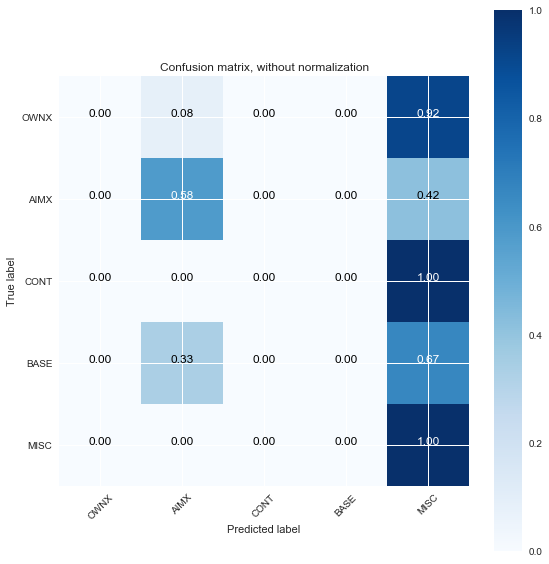

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        12
          1       0.78      0.58      0.67        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.48      1.00      0.65        25

avg / total       0.35      0.52      0.40        61

undersample1 count1
Mean CV LogLoss: 2.746


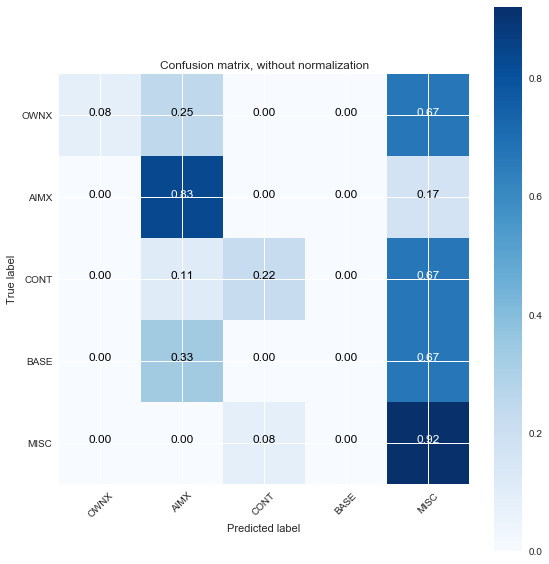

             precision    recall  f1-score   support

          0       1.00      0.08      0.15        12
          1       0.67      0.83      0.74        12
          2       0.50      0.22      0.31         9
          3       0.00      0.00      0.00         3
          4       0.56      0.92      0.70        25

avg / total       0.63      0.59      0.51        61

undersample1 tfidf1
Mean CV LogLoss: 1.338


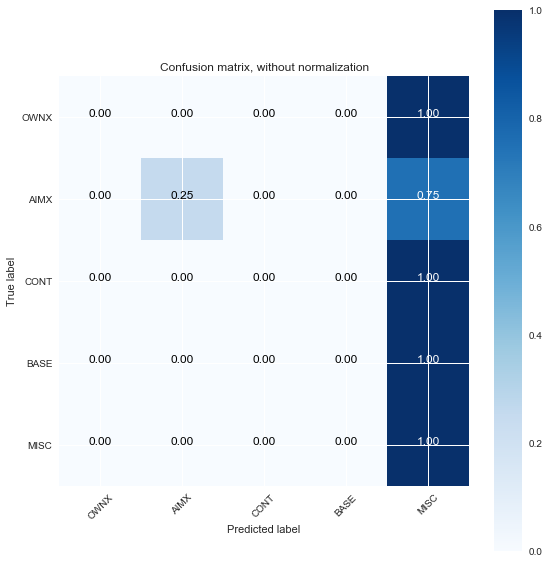

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        12
          1       1.00      0.25      0.40        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.43      1.00      0.60        25

avg / total       0.37      0.46      0.33        61

undersample1 count2
Mean CV LogLoss: 2.813


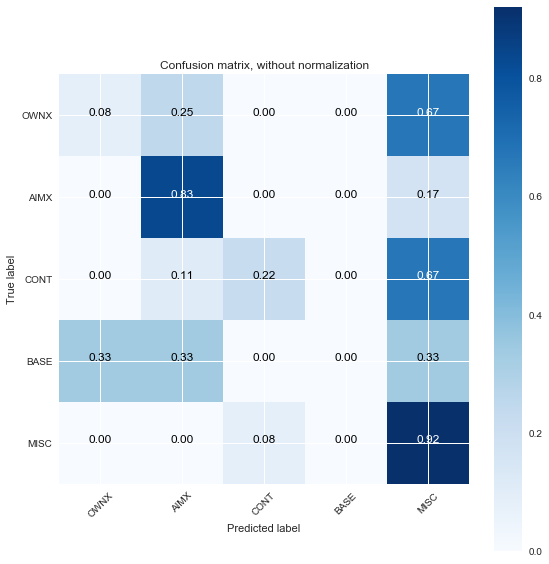

             precision    recall  f1-score   support

          0       0.50      0.08      0.14        12
          1       0.67      0.83      0.74        12
          2       0.50      0.22      0.31         9
          3       0.00      0.00      0.00         3
          4       0.57      0.92      0.71        25

avg / total       0.54      0.59      0.51        61

undersample1 tfidf2
Mean CV LogLoss: 1.362


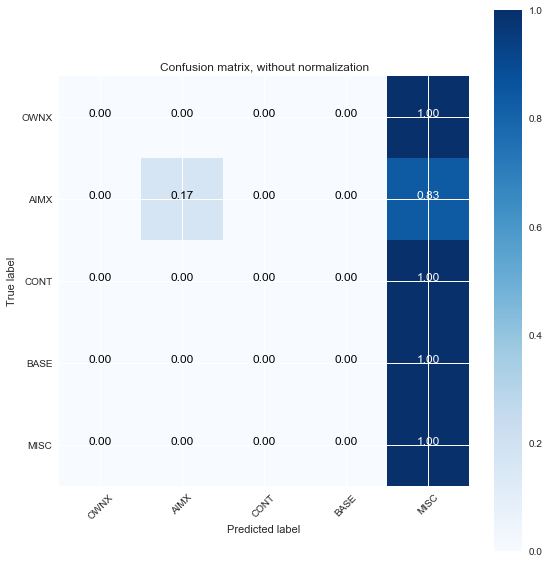

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        12
          1       1.00      0.17      0.29        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.42      1.00      0.60        25

avg / total       0.37      0.44      0.30        61

Length of training set: 380
Length of test set: 34595
The Distribution of labels: 
OWNX: 33.68% 
AIMX: 16.84% 
CONT: 11.84% 
BASE: 3.95% 
MISC: 33.68%
undersample2 count0
Mean CV LogLoss: 2.411


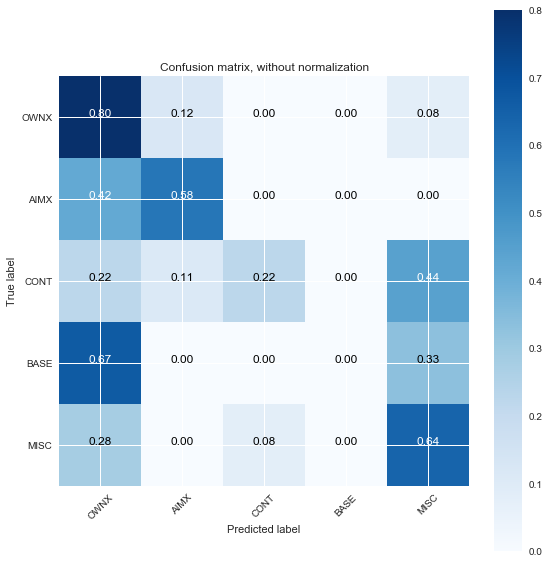

             precision    recall  f1-score   support

          0       0.56      0.80      0.66        25
          1       0.64      0.58      0.61        12
          2       0.50      0.22      0.31         9
          3       0.00      0.00      0.00         3
          4       0.70      0.64      0.67        25

avg / total       0.59      0.61      0.58        74

undersample2 tfidf0
Mean CV LogLoss: 1.284


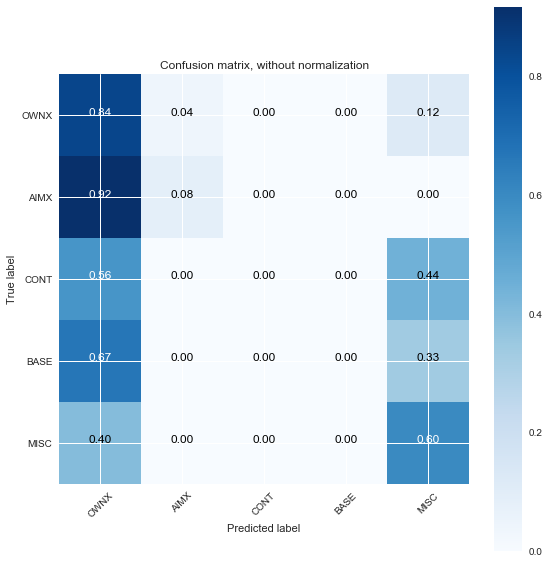

             precision    recall  f1-score   support

          0       0.43      0.84      0.57        25
          1       0.50      0.08      0.14        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.65      0.60      0.63        25

avg / total       0.45      0.50      0.43        74

undersample2 count1
Mean CV LogLoss: 2.727


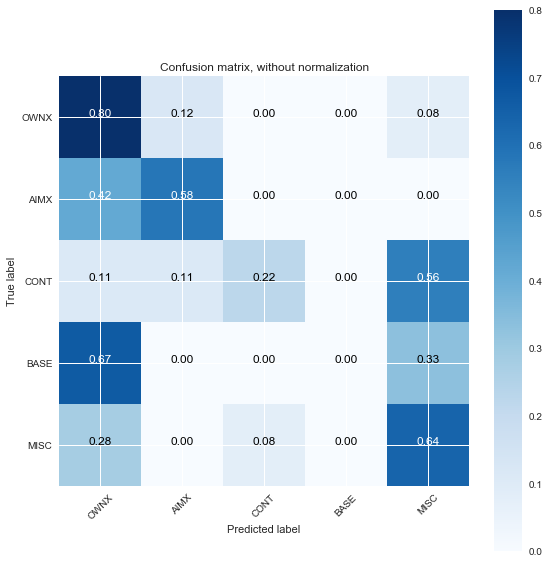

             precision    recall  f1-score   support

          0       0.57      0.80      0.67        25
          1       0.64      0.58      0.61        12
          2       0.50      0.22      0.31         9
          3       0.00      0.00      0.00         3
          4       0.67      0.64      0.65        25

avg / total       0.58      0.61      0.58        74

undersample2 tfidf1
Mean CV LogLoss: 1.317


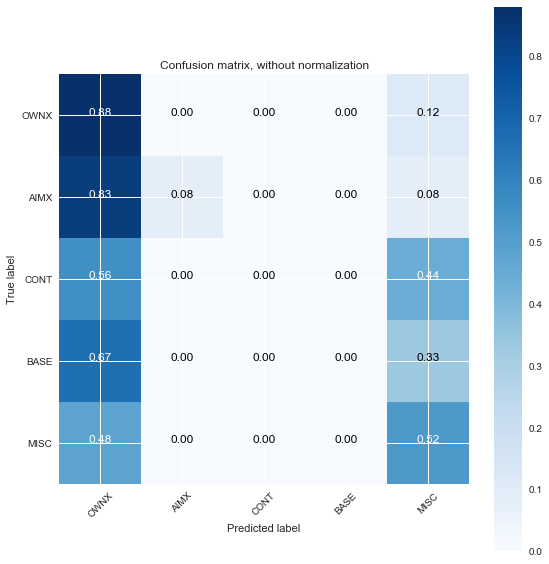

             precision    recall  f1-score   support

          0       0.43      0.88      0.58        25
          1       1.00      0.08      0.15        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.59      0.52      0.55        25

avg / total       0.51      0.49      0.41        74

undersample2 count2
Mean CV LogLoss: 2.812


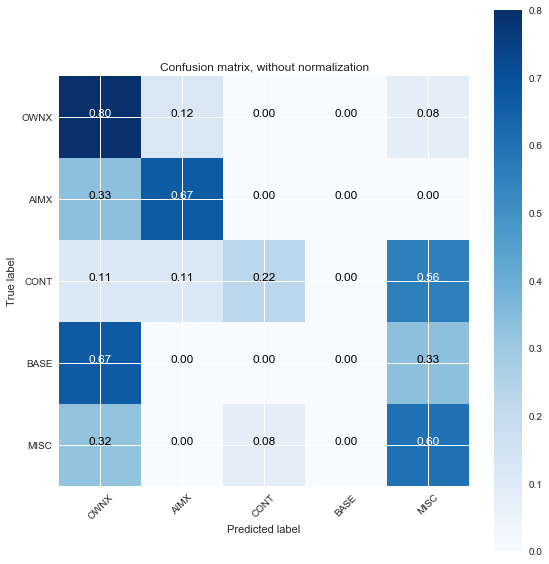

             precision    recall  f1-score   support

          0       0.57      0.80      0.67        25
          1       0.67      0.67      0.67        12
          2       0.50      0.22      0.31         9
          3       0.00      0.00      0.00         3
          4       0.65      0.60      0.63        25

avg / total       0.58      0.61      0.58        74

undersample2 tfidf2
Mean CV LogLoss: 1.340


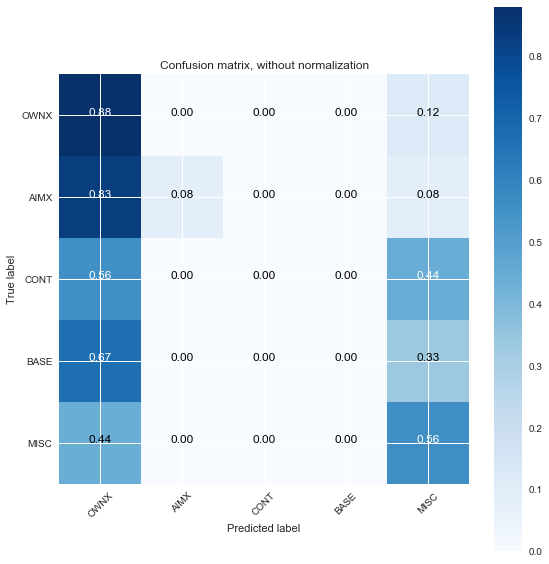

             precision    recall  f1-score   support

          0       0.44      0.88      0.59        25
          1       1.00      0.08      0.15        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.61      0.56      0.58        25

avg / total       0.52      0.50      0.42        74

Length of training set: 444
Length of test set: 34595
The Distribution of labels: 
OWNX: 28.83% 
AIMX: 14.41% 
CONT: 10.14% 
BASE: 3.38% 
MISC: 43.24%
undersample3 count0
Mean CV LogLoss: 2.560


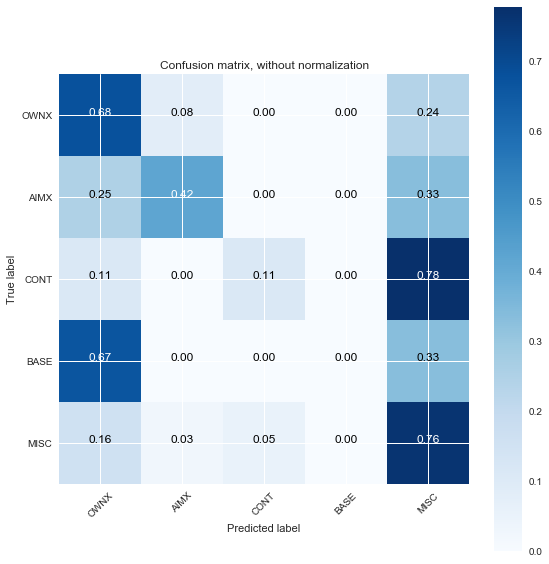

             precision    recall  f1-score   support

          0       0.59      0.68      0.63        25
          1       0.62      0.42      0.50        12
          2       0.33      0.11      0.17         9
          3       0.00      0.00      0.00         3
          4       0.62      0.76      0.68        38

avg / total       0.56      0.60      0.57        87

undersample3 tfidf0
Mean CV LogLoss: 1.234


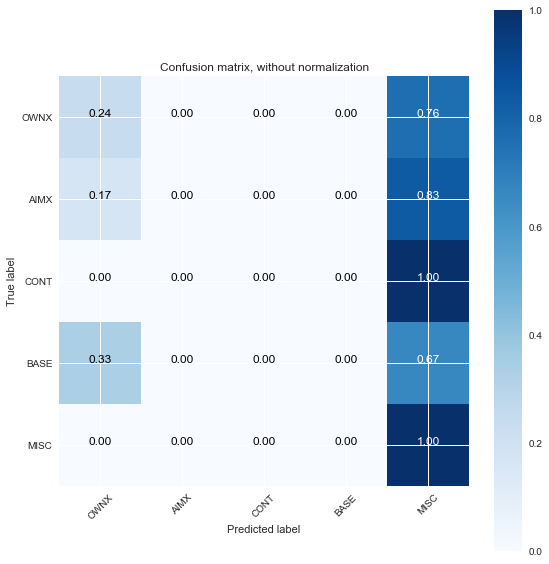

             precision    recall  f1-score   support

          0       0.67      0.24      0.35        25
          1       0.00      0.00      0.00        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.49      1.00      0.66        38

avg / total       0.40      0.51      0.39        87

undersample3 count1
Mean CV LogLoss: 2.919


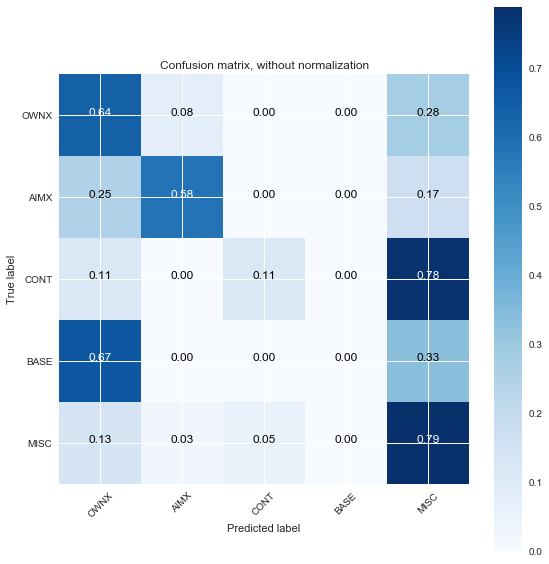

             precision    recall  f1-score   support

          0       0.59      0.64      0.62        25
          1       0.70      0.58      0.64        12
          2       0.33      0.11      0.17         9
          3       0.00      0.00      0.00         3
          4       0.64      0.79      0.71        38

avg / total       0.58      0.62      0.59        87

undersample3 tfidf1
Mean CV LogLoss: 1.258


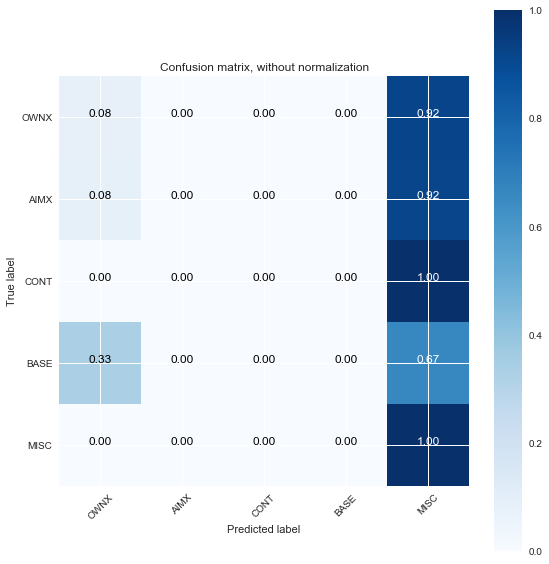

             precision    recall  f1-score   support

          0       0.50      0.08      0.14        25
          1       0.00      0.00      0.00        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.46      1.00      0.63        38

avg / total       0.34      0.46      0.31        87

undersample3 count2
Mean CV LogLoss: 2.997


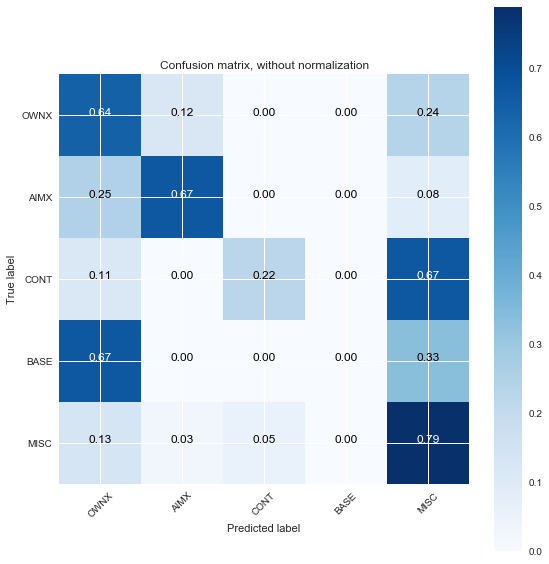

             precision    recall  f1-score   support

          0       0.59      0.64      0.62        25
          1       0.67      0.67      0.67        12
          2       0.50      0.22      0.31         9
          3       0.00      0.00      0.00         3
          4       0.68      0.79      0.73        38

avg / total       0.61      0.64      0.62        87

undersample3 tfidf2
Mean CV LogLoss: 1.278


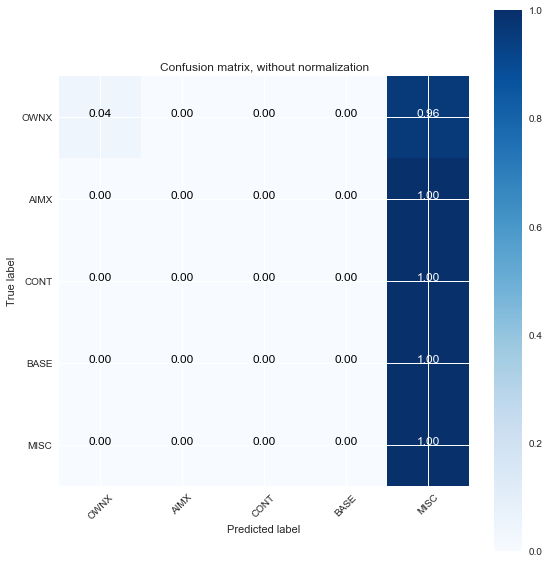

             precision    recall  f1-score   support

          0       1.00      0.04      0.08        25
          1       0.00      0.00      0.00        12
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         3
          4       0.44      1.00      0.61        38

avg / total       0.48      0.45      0.29        87



In [66]:
# Undersample data
ratio = [[1,1,1], [2,1,1], [2,2,1], [3,2,1]]
undersample = dict()
for i, val in enumerate(ratio):
    undersample[i] = undersampling(labeled3, val)

# MultinomialNB in countvectorizer and tfidfvectorizer
estimator =  MultinomialNB()
test = unlabeled
count1 = dict()
tfidf1 = dict()

for i in range(4):
    train = undersample[i]
    print('Length of training set: {}'.format(train.shape[0]))
    print('Length of test set: {}'.format(test.shape[0]))
    check_dist(train)
    for j in range(3):
        print('undersample'+str(i)+' count'+str(j))
        vectorizer = vectorizers_count[j]
        count1[j] = text_model(estimator, vectorizer, train, test, cv=5)
        print('undersample'+str(i)+' tfidf'+str(j))
        vectorizer = vectorizers_tfidf[j]
        tfidf1[j] = text_model(estimator, vectorizer, train, test, cv=5)

## 5.3 Oversampling
Based on the plot, we need to oversample 'OWNX', 'CONT', 'AIMX', 'BASE' labels as they are the minorities.

In [67]:
def oversampling(data, prop):
    """
    This function oversample 'OWNX', 'CONT', 'AIMX', 'BASE' using 'MISC' labels as proportion.
    prop is a list [a,b,c,d,e] with a -> 'OWNX', b -> 'AIMX', c -> 'CONT', d -> 'BASE', e -> 'MISC'
    For example, [1,1,1,1,1] implies all data have equal proportion
    """    
    # count number of 'AIMX' data
    ownx_counts = len(data[data['labels']=='OWNX'])
    aimx_counts = len(data[data['labels']=='AIMX'])
    cont_counts = len(data[data['labels']=='CONT'])
    base_counts = len(data[data['labels']=='BASE'])
    misc_counts = len(data[data['labels']=='MISC'])
    lst1 = [ownx_counts, aimx_counts, cont_counts, base_counts, misc_counts]
    
    lst2 = ['ownx', 'aimx', 'cont', 'base']
    # oversample data by creating copy
    for i in range(4):
        no_of_copy = round((misc_counts*prop[i]/prop[4] - lst1[i])/lst1[i])
        for j in range(no_of_copy):
            data = data.append(data[data['labels']==lst2[i]])
    
    # check undersample_data distribution
    check_dist(data)
    
    return data

In [68]:
# oversample data
ratio = [[1,1,1,1,1], [1,1,1,1,2], [2,1,1,1,2], [2,1,1,1,3]]
oversample = dict()
for i, val in enumerate(ratio):
    oversample[i] = oversampling(labeled3, val)

# MultinomialNB in countvectorizer and tfidfvectorizer
estimator =  MultinomialNB()
test = unlabeled
count1 = dict()
tfidf1 = dict()

for i in range(4):
    train = undersample[i]
    print('Length of training set: {}'.format(train.shape[0]))
    print('Length of test set: {}'.format(test.shape[0]))
    check_dist(train)
    for j in range(3):
        print('undersample'+str(i)+' count'+str(j))
        vectorizer = vectorizers_count[j]
        count1[j] = text_model(estimator, vectorizer, train, test, cv=5)
        print('undersample'+str(i)+' tfidf'+str(j))
        vectorizer = vectorizers_tfidf[j]
        tfidf1[j] = text_model(estimator, vectorizer, train, test, cv=5)

NameError: name 'undersample_data' is not defined

The logloss does not improve much, although some setting give some improvement, it is not much. Let's try SMOTE and XGBoost.

## 5.4 SMOTE
Oversample data by creating synthetic sample using SMOTE module.

In [73]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

from collections import Counter

from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

X = labeled3.drop('labels',axis=1)
y = labeled3['labels']

RANDOM_STATE = 2018

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

# Create a pipeline
pipeline = make_pipeline(NearMiss(version=2, random_state=RANDOM_STATE),
                         LinearSVC(random_state=RANDOM_STATE))
pipeline.fit(X_train, y_train)

# Classify and report the results
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

Training target statistics: Counter({'MISC': 471, 'OWNX': 216, 'AIMX': 49, 'CONT': 30, 'BASE': 13})
Testing target statistics: Counter({'MISC': 154, 'OWNX': 74, 'CONT': 15, 'AIMX': 15, 'BASE': 2})


ValueError: could not convert string to float: 'results provide bleak view how well people learn feedback avoid sces'

annotator article_id  domain  \
0         1          7       0   
1         1          7       0   
2         1          7       0   
3         1          7       0   
4         1          7       0   

                                               texts  type  num_words  \
0  The Minimum Description Length principle for o...     0         16   
1  If the underlying model class is discrete, the...     0         38   
2  For MDL, in general one can only have loss bou...     0         21   
3  We show that this is even the case if the mode...     0         16   
4  We derive a new upper bound on the prediction ...     0         14   

   num_unique_words  num_chars  num_punctuations  num_words_upper  \
0                16        120                 1                0   
1                33        267                 8                0   
2                21        121                 1                1   
3                15         91                 0                0   
4                14         83                 0                0   

   mean_word_len  num_stopwords  \
0       6.562500              5   
1       6.052632             10   
2       4.809524              7   
3       4.750000              4   
4       5.000000              4   

                                        text_cleaned  
0  minimum description length principle online se...  
1  if underlying class discrete then total expect...  
2  mdl general one only loss bounds finite but ex...  
3  even case if class contains only bernoulli dis...  
4  derive upper bound prediction error countable ...

In [ ]:
# oversample data
ratio = [[1,1,1,1,1], [1,1,1,1,2], [2,1,1,1,2], [2,1,1,1,3]]
oversample = dict()
for i, val in enumerate(ratio):
    oversample[i] = oversampling(labeled3, val)

# MultinomialNB in countvectorizer and tfidfvectorizer
estimator =  RandomForestClassifier()
test = unlabeled
count1 = dict()
tfidf1 = dict()

for i in range(4):
    train = undersample[i]
    for j in range(3):
        print('undersample'+str(i)+' count'+str(j))
        vectorizer = vectorizers_count[j]
        count1[j] = text_model(estimator, vectorizer, train, test, cv=5)
        print('undersample'+str(i)+' tfidf'+str(j))
        vectorizer = vectorizers_tfidf[i]
        tfidf1[j] = text_model(estimator, vectorizer, train, test, cv=5)

In [70]:
labeled.describe()

domain         type    num_words  num_unique_words    num_chars  \
count  3118.000000  3118.000000  3118.000000       3118.000000  3118.000000   
mean      1.039128     0.806607    24.535279         21.682809   163.237973   
std       0.820656     0.395022    10.722079          8.285631    74.083036   
min       0.000000     0.000000     4.000000          4.000000    22.000000   
25%       0.000000     1.000000    17.000000         16.000000   111.000000   
50%       1.000000     1.000000    23.000000         21.000000   153.000000   
75%       2.000000     1.000000    30.000000         26.000000   202.000000   
max       2.000000     1.000000    91.000000         61.000000   654.000000   

       num_punctuations  num_words_upper  mean_word_len  num_stopwords  
count       3118.000000      3118.000000    3118.000000    3118.000000  
mean           2.183451         0.879731       5.641725       7.516998  
std            2.169662         1.319129       0.740153       3.851119  
min            0.000000         0.000000       2.714286       0.000000  
25%            1.000000         0.000000       5.176471       5.000000  
50%            2.000000         0.000000       5.640000       7.000000  
75%            3.000000         1.000000       6.090909      10.000000  
max           17.000000        12.000000       8.200000      26.000000

In [ ]:
from imblearn.over_sampling import SMOTE 
ownx = labeled3.loc[labeled3['labels']=='OWNX']
aimx = labeled3.loc[labeled3['labels']=='AIMX']
cont = labeled3.loc[labeled3['labels']=='CONT']
base = labeled3.loc[labeled3['labels']=='BASE']
misc = labeled3.loc[labeled3['labels']=='MISC']
X = labeled3.drop(columns = 'labels')
sm = SMOTE(random_state=2018)
check_dist(data):
X_res, y_res = sm.fit_sample(X, y)



from collections import Counter
from sklearn.datasets import make_classification

X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape {}'.format(Counter(y)))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

In [ ]:
# Lets Use SMOTE for Sampling
# As I mentioned it is also a type of oversampling but in this the data is not replicated but they are created 
#lets start with importing libraries

data = pd.read_csv('../input/creditcard.csv')
In [32]:
os = SMOTE(random_state=0) #   We are using SMOTE as the function for oversampling
# now we can devided our data into training and test data
# Call our method data prepration on our dataset
data_train_X,data_test_X,data_train_y,data_test_y=data_prepration(data)
columns = data_train_X.columns
length of training data
199364
length of test data
85443
In [33]:
# now use SMOTE to oversample our train data which have features data_train_X and labels in data_train_y
os_data_X,os_data_y=os.fit_sample(data_train_X,data_train_y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=["Class"])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of normal transcation in oversampled data",len(os_data_y[os_data_y["Class"]==0]))
print("No.of fraud transcation",len(os_data_y[os_data_y["Class"]==1]))
print("Proportion of Normal data in oversampled data is ",len(os_data_y[os_data_y["Class"]==0])/len(os_data_X))
print("Proportion of fraud data in oversampled data is ",len(os_data_y[os_data_y["Class"]==1])/len(os_data_X))
length of oversampled data is  398078
Number of normal transcation in oversampled data 199039
No.of fraud transcation 199039
Proportion of Normal data in oversampled data is  0.5
Proportion of fraud data in oversampled data is  0.5
By using Smote we are getting a 50 - 50 each

No need of checking here in over sampled data itself from previous we know it will be overfitting

let us check with the test data direct

In [34]:
# Let us first do our amount normalised and other that we are doing above
os_data_X["Normalized Amount"] = StandardScaler().fit_transform(os_data_X['Amount'].reshape(-1, 1))
os_data_X.drop(["Time","Amount"],axis=1,inplace=True)
data_test_X["Normalized Amount"] = StandardScaler().fit_transform(data_test_X['Amount'].reshape(-1, 1))
data_test_X.drop(["Time","Amount"],axis=1,inplace=True)

In [ ]:
# vectorize the text
tfidf_vec1 = TfidfVectorizer(min_df=0, ngram_range=(1,1))
tfidf_vec2 = TfidfVectorizer(min_df=0, ngram_range=(1,2))
tfidf_vec3 = TfidfVectorizer(min_df=0, ngram_range=(1,3))

count_vec1 = CountVectorizer(min_df=0, ngram_range=(1,1))
count_vec2 = CountVectorizer(min_df=0, ngram_range=(1,2))
count_vec3 = CountVectorizer(min_df=0, ngram_range=(1,3))

full_tfidf_1 = tfidf_vec1.fit_transform(labeled['text cleaned'].values.tolist() + unlabeled['text cleaned'].values.tolist())
labeled_tfidf_1 = tfidf_vec1.fit_transform(labeled['text cleaned'].values.tolist())
unlabeled_tfidf_1 = tfidf_vec1.fit_transform(unlabeled['text cleaned'].values.tolist())

full_tfidf_2 = tfidf_vec2.fit_transform(labeled['text cleaned'].values.tolist() + unlabeled['text cleaned'].values.tolist())
labeled_tfidf_2 = tfidf_vec2.fit_transform(labeled['text cleaned'].values.tolist())
unlabeled_tfidf_2 = tfidf_vec2.fit_transform(unlabeled['text cleaned'].values.tolist())

full_tfidf_3 = tfidf_vec3.fit_transform(labeled['text cleaned'].values.tolist() + unlabeled['text cleaned'].values.tolist())
labeled_tfidf_3 = tfidf_vec3.fit_transform(labeled['text cleaned'].values.tolist())
unlabeled_tfidf_3 = tfidf_vec3.fit_transform(unlabeled['text cleaned'].values.tolist())

full_count_1 = count_vec1.fit_transform(labeled['text cleaned'].values.tolist() + unlabeled['text cleaned'].values.tolist())
labeled_count_1 = count_vec1.fit_transform(labeled['text cleaned'].values.tolist())
unlabeled_count_1 = count_vec1.fit_transform(unlabeled['text cleaned'].values.tolist())

full_count_2 = count_vec2.fit_transform(labeled['text cleaned'].values.tolist() + unlabeled['text cleaned'].values.tolist())
labeled_count_2 = count_vec2.fit_transform(labeled['text cleaned'].values.tolist())
unlabeled_count_2 = count_vec2.fit_transform(unlabeled['text cleaned'].values.tolist())

full_count_3 = count_vec3.fit_transform(labeled['text cleaned'].values.tolist() + unlabeled['text cleaned'].values.tolist())
labeled_count_3 = count_vec3.fit_transform(labeled['text cleaned'].values.tolist())
unlabeled_count_3 = count_vec3.fit_transform(unlabeled['text cleaned'].values.tolist())

CountVectorizer only counts the word frequency, while TfidVectorizer counts and normalize its results. TfidfVectorizer value increase proportionally to count, but is offset by frequency of words in the corpus.

- "min_df" in the parameter refers to the minimum document frequency and the vectorizer will simply drop all words that occur less than that value set. We set it as 0 as we don't want to drop anything.

- "ngram_range" in the parameter refers to tuple (min_n, max_n) the lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used.

## 5.1 Naive Bayes

In [ ]:
text_model(estimator, train, test, vectorizer, prefix, cv=5)
estimator = MultinomialNB()
text_model(estimator, labeled, unlabeled,  )

In [ ]:
vectorizers = [full_count_1, full_count_2, full_count_3, 
              labeled_count_1, labeled_count_2, labeled_count_3,
              unlabeled_count_1, unlabeled_count_2, unlabeled_count_3,
              full_tfidf_1, full_tfidf_2, full_tfidf_3, 
              labeled_tfidf_1, labeled_count_2, labeled_tfidf_3,
              unlabeled_tfidf_1, unlabeled_tfidf_2, unlabeled_tfidf_3,]

X = tfidf_vec.fit_transform(labeled.text_cleaned)
y = labeled['labels']


scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

# Multinomial Naive Bayes on Count Vectorizer
X = count_vec.fit_transform(labeled.text_cleaned)
y = labeled['labels']
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

## 5.2 Build Predictive Model
We will build predictive model with tfidfvectorizer, countvectorizer, Naive Bayes and XGBoost.

**Note**: According to log loss equation:
![](https://i.stack.imgur.com/NEmt7.png)
Log loss exists on the range [0, ∞), when log loss exceeds 1, it is when log(pij) < -1 when i is the true class. This means that the predicted probability for given class would be less than exp(-1) or around 0.368. This imply that the model only gives less than a 36% probability estimate for the actual class.

### 5.2.1 Naive Bayes

In [ ]:
# vectorize the text
tfidf_vec = TfidfVectorizer(min_df=0, ngram_range=(1,1))
count_vec = CountVectorizer(min_df=0, ngram_range=(1,1))

X = tfidf_vec.fit_transform(labeled.text_cleaned)
y = labeled['labels']


scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

# Multinomial Naive Bayes on Count Vectorizer
X = count_vec.fit_transform(labeled.text_cleaned)
y = labeled['labels']
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

In [ ]:
# vectorize and  the text
tfidf_vec = TfidfVectorizer(min_df=0, ngram_range=(1,2))
count_vec = CountVectorizer(min_df=0, ngram_range=(1,2))

# Multinomial Naive Bayes on Tfidf Vectorizer
X = tfidf_vec.fit_transform(labeled.text_cleaned)
y = labeled['labels']
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

# Multinomial Naive Bayes on Count Vectorizer
X = count_vec.fit_transform(labeled.text_cleaned)
y = labeled['labels']
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

### 5.2.1 XGBoost

In [ ]:
# vectorize the text 
tfidf_vec = TfidfVectorizer(min_df=0, ngram_range=(1,2))
count_vec = CountVectorizer(min_df=0, ngram_range=(1,2))

y = labeled['labels']

# xgbc with only meta data
X_meta = labeled[['domain', 'type', 'num_words', 'num_unique_words', 'num_chars', 
         'num_punctuations', 'num_words_upper', 'mean_word_len']]

xgbc = xgb.XGBClassifier(objective='multi:softprob', n_estimators=200)
scores = cross_val_score(xgbc, X_meta, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

In [ ]:
xgbc.fit(X_meta, y)
xgb.plot_importance(xgbc);

In [ ]:
# xgbc with only 2 meta data
X_meta = labeled[['mean_word_len', 'num_chars']]

xgbc = xgb.XGBClassifier(objective='multi:softprob', n_estimators=200)
scores = cross_val_score(xgbc, X_meta, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

In [ ]:
print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))

In [1]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

from collections import Counter

from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

print(__doc__)

RANDOM_STATE = 42

# Create a folder to fetch the dataset
iris = load_iris()
X, y = make_imbalance(iris.data, iris.target, ratio={0: 25, 1: 50, 2: 50},
                      random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE)

print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

# Create a pipeline
pipeline = make_pipeline(NearMiss(version=2, random_state=RANDOM_STATE),
                         LinearSVC(random_state=RANDOM_STATE))
pipeline.fit(X_train, y_train)

# Classify and report the results
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

Automatically created module for IPython interactive environment
Training target statistics: Counter({1: 38, 2: 38, 0: 17})
Testing target statistics: Counter({1: 12, 2: 12, 0: 8})
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00         8
          1       1.00      0.83      1.00      0.91      0.95      0.92        12
          2       0.86      1.00      0.90      0.92      0.93      0.84        12

avg / total       0.95      0.94      0.96      0.94      0.95      0.91        32



In [12]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss 
X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
print('Original dataset shape {}'.format(Counter(y)))
nm = NearMiss(random_state=42)
X_res, y_res = nm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))


def stack_ensemble(estimator, train, test, vectorizer, resampler, prefix, RANDOM_STATE=2018, cv=5, plot=False):
    """
    This function will:
        - test oversample, undersample and mixed sample methods
        - print the imbalanced classifcation reports
        - add prediction as new features
        
    Note: naming convention: estimator_vectorizer_resampler_labels
    Example: MultinomialNB, CountVectorizer, SMOTE, MISC -> MNB_Count_SMOTE_MISC
    The first two parts are created manually as input.
    """
    #X = train.drop(columns=['labels','texts','text_cleaned'])
    y = train['labels']
    textdata = train['text_cleaned'].append(test['text_cleaned']) 
    full_vec = vectorizer.fit_transform(textdata)
    test_vec = vectorizer.transform(test['text_cleaned'])
    train_vec = vectorizer.transform(train['text_cleaned'])

    print('Original dataset shape {}'.format(Counter(y)))
    # resample training data and validation sets
    X_res, y_res = resampler.fit_sample(train_vec, y)
    print('Resampled dataset shape {}'.format(Counter(y_res)))
    """
    input : X_res, y_res, test_vec, train_vec
    """
    # Cross-validation    
    cv_scores = []
    pred_train = np.zeros([X_res.shape[0],5])
    skf = StratifiedKFold(n_splits = cv, shuffle=True, random_state=2018)
    pred_full_test = 0
    
    for dev_idx, val_idx in skf.split(X_res, y_res):
        # split train and test into training and validation sets
        # training sets: training, target_training
        # validation sets: valid, target_valid
        training, valid = X_res[dev_idx], X_res[val_idx]
        target_training, target_valid = y_res[dev_idx], y_res[val_idx]
        
        # fit the model
        estimator.fit(training, target_training)
        # predict validation set
        pred_valid = estimator.predict_proba(valid)        
        pred_test = estimator.predict_proba(test_vec)
        pred_full_test = pred_full_test + pred_test
        pred_train[val_idx, :] = pred_valid
        cv_scores.append(log_loss(target_valid, pred_valid))       
        
    # print output
    print('Mean CV LogLoss: {:.3f}'.format(np.mean(cv_scores)))
    pred_full_test = np.round(pred_full_test / cv)
    print(classification_report_imbalanced(target_valid, np.argmax(pred_valid, axis=1)))
    
    # np.argmax(pred_val)
    if plot == True:
        # plot confusion matrix
        cnf_matrix = confusion_matrix(target_valid, np.argmax(pred_valid, axis=1))
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure(figsize=(8,8))
        plot_confusion_matrix(cnf_matrix, classes=['OWNX', 'AIMX', 'CONT', 'BASE', 'MISC'], 
                              normalize = True, title='Confusion matrix, without normalization')
        plt.show()
            
    # add the predictions as new features

    new_train.loc[:, prefix+"_OWNX"] = pred_train[:,0]
    new_train.loc[:, prefix+"_AIMX"] = pred_train[:,1]
    new_train.loc[:, prefix+"_CONT"] = pred_train[:,2]
    new_train.loc[:, prefix+"_BASE"] = pred_train[:,3]
    new_train.loc[:, prefix+"_MISC"] = pred_train[:,4]
    new_test.loc[:, prefix+"_OWNX"] = pred_full_test[:,0]
    new_test.loc[:, prefix+"_AIMX"] = pred_full_test[:,1]
    new_test.loc[:, prefix+"_CONT"] = pred_full_test[:,2]
    new_test.loc[:, prefix+"_BASE"] = pred_full_test[:,3]
    new_test.loc[:, prefix+"_MISC"] = pred_full_test[:,4]

    return new_train, test, y_res

Original dataset shape Counter({0: 1})
Resampled dataset shape Counter({0: 100, 1: 100})


C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
X_res

array([[ 0.60013068, -1.42766402, -0.8128431 , ..., -0.55302378,
         0.14876985, -1.74795877],
       [-0.90046724,  2.78334347,  0.32973806, ...,  0.45669534,
         0.8504395 , -2.15786403],
       [-0.63473483, -0.95609451,  1.68636505, ...,  0.03244581,
        -0.32016924, -0.5227425 ],
       ..., 
       [ 0.53031893,  1.33598778, -0.12628064, ..., -1.47011255,
         0.34828884, -1.16559387],
       [-0.45517392, -0.15463612, -1.3282851 , ..., -0.30380274,
         1.86677974, -0.81674552],
       [-0.06444393,  1.87158557,  0.04563918, ...,  1.43375434,
         0.83150475, -2.54038659]])

In [ ]:
submission = pd.DataFrame({
"texts": [1,2,3],
"labels": ['a', 'b', 'c']
})
submission.to_csv(r'C:\Users\LW130003\Desktop\New folder\SentenceCorpus\submission.csv', index=False)